In [1]:
lr_D = 1e-3
lr_G = 1e-3
beta1 = 0.5
epoch = int(1e4) 
fig_report_period = int(1e3) 
batch_size = 100
dim_z = 100 
layer_widths_G = [dim_z, 128, 784]
layer_widths_D = [784, 128, 1]

In [2]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import tensorflow.compat.v1 as tf; tf.disable_v2_behavior()
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
os.makedirs('out_grid', exist_ok=True)
os.makedirs('out_random', exist_ok=True)

In [4]:
def plot(samples):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))
    for ax, sample in zip(axes.reshape((-1,)), samples):
        img = sample.reshape((28,28))   
        ax.imshow(img, cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    return fig

In [5]:
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

In [7]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 784)) # (?, 784)
z = tf.placeholder(tf.float32, (None, 100)) # (?, 100)
dropout_rate = tf.placeholder(tf.float32, []) 

init_w = tf.keras.initializers.VarianceScaling(seed=0)
init_b = tf.keras.initializers.zeros()

w_shapes_G = []
previous = layer_widths_G[0] 
for i, layer_width in enumerate(layer_widths_G[1:]):
    w_shapes_G.append((previous, layer_width))
    previous = layer_width

# Generator
theta_G = []
for i, (pre, layer_width) in enumerate(w_shapes_G):
    w_name = f'w{i}_generator'
    b_name = f'b{i}_generator'
    w = tf.get_variable(w_name, (pre, layer_width), tf.float32, init_w)
    b = tf.get_variable(b_name, (layer_width,), tf.float32, init_b)
    theta_G.append(w)
    theta_G.append(b)
    if i==0:
        x1 = tf.nn.relu(z @ w + b)
        x1 = tf.nn.dropout(x1, rate=dropout_rate, seed=0)
    else:
        x_fake = tf.nn.sigmoid(x1 @ w + b)
        x_fake = tf.clip_by_value(x_fake, 1e-8, 1 - 1e-8)
        
w_shapes_D = []
previous = layer_widths_D[0] 
for i, layer_width in enumerate(layer_widths_D[1:]):
    w_shapes_D.append((previous, layer_width))
    previous = layer_width

# Discriminator
theta_D = []
for i, (pre, layer_width) in enumerate(w_shapes_D):
    w_name = f'w{i}_discriminator'
    b_name = f'b{i}_discriminator'
    w = tf.get_variable(w_name, (pre, layer_width), tf.float32, init_w)
    b = tf.get_variable(b_name, (layer_width,), tf.float32, init_b)
    theta_D.append(w)
    theta_D.append(b)
    if i==0:
        x1_real = tf.nn.relu(x @ w + b)
        x1_real = tf.nn.dropout(x1_real, rate=dropout_rate, seed=0)
        x1_fake = tf.nn.relu(x_fake @ w + b)
        x1_fake = tf.nn.dropout(x1_fake, rate=dropout_rate, seed=0)
    else:
        logits_real = x1_real @ w + b 
        logits_fake = x1_fake @ w + b
        
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits_fake,
        labels=tf.ones_like(logits_fake)
    )
)
G_train = tf.train.AdamOptimizer(learning_rate=lr_G, beta1=beta1).minimize(G_loss, var_list=theta_G)
        
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits_real, 
        labels=tf.ones_like(logits_real)
    )
)
D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits_fake, 
        labels=tf.zeros_like(logits_fake)
    )
)
D_loss = D_loss_real + D_loss_fake
D_train = tf.train.AdamOptimizer(learning_rate=lr_D, beta1=beta1).minimize(D_loss, var_list=theta_D)

init = tf.global_variables_initializer()

In [8]:
x_grid = np.linspace(-1., 1., 4)
y_grid = np.linspace(-1., 1., 4)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid, Y_grid = X_grid.reshape((-1,1)), Y_grid.reshape((-1,1))
Zeros = np.zeros((X_grid.shape[0], dim_z-2))
z_grid = np.concatenate([X_grid, Y_grid, Zeros], axis=1)

z_sample = sample_z(batch_size, dim_z)

with tf.Session() as sess:
    
    sess.run(init)
    
    G_loss_trace = []
    D_loss_trace = []

    fig_report_index = 0
    fig_index = 0
    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            if fig_report_index % fig_report_period == 0:

                feed_dict = {z: z_grid, dropout_rate: 0.0}
                samples = sess.run(x_fake, feed_dict=feed_dict)
                
                fig = plot(samples)
                plt.savefig('out_grid/{}.png'.format(str(fig_index).zfill(3)), bbox_inches='tight')
                plt.close(fig)
    
                feed_dict = {z: z_sample, dropout_rate: 0.0}
                samples = sess.run(x_fake, feed_dict=feed_dict)
                
                fig = plot(samples)
                plt.savefig('out_random/{}.png'.format(str(fig_index).zfill(3)), bbox_inches='tight')
                plt.close(fig)
                
                fig_index += 1
        
            if k==0:
                G_loss_temp = []
                D_loss_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            z_batch = sample_z(batch_size, dim_z)
            feed_dict = {x: x_batch, z: z_batch, dropout_rate: 0.1}

            _, G_loss_run = sess.run([G_train, G_loss], feed_dict=feed_dict)
            _, D_loss_run = sess.run([D_train, D_loss], feed_dict=feed_dict)
            fig_report_index += 1
            
            G_loss_temp.append(G_loss_run)
            D_loss_temp.append(D_loss_run)
        
        G_loss_avg = np.array(G_loss_temp).mean()
        D_loss_avg = np.array(D_loss_temp).mean()
        G_loss_trace.append(G_loss_avg)
        D_loss_trace.append(D_loss_avg)
        print(f'{i+1}/{epoch} G_loss {G_loss_avg}, D_loss {D_loss_avg}')
    
    x_grid = np.linspace(-1., 1., 40)
    y_grid = np.linspace(-1., 1., 40)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    X_grid, Y_grid = X_grid.reshape((-1,1)), Y_grid.reshape((-1,1))
    Zeros = np.zeros((X_grid.shape[0], dim_z-2))
    z_grid = np.concatenate([X_grid, Y_grid, Zeros], axis=1)
    
    feed_dict = {z: z_grid, dropout_rate: 0.0}
    latent_space_walk = sess.run(x_fake, feed_dict=feed_dict)

1/10000 G_loss 2.726602077484131, D_loss 0.3070887625217438
2/10000 G_loss 2.788048505783081, D_loss 0.3359447121620178
3/10000 G_loss 2.5388219356536865, D_loss 0.41330716013908386
4/10000 G_loss 2.528679609298706, D_loss 0.46275559067726135
5/10000 G_loss 2.3670787811279297, D_loss 0.529232919216156
6/10000 G_loss 2.440514087677002, D_loss 0.5257581472396851
7/10000 G_loss 2.4486443996429443, D_loss 0.5252963304519653
8/10000 G_loss 2.479543447494507, D_loss 0.5304234027862549
9/10000 G_loss 2.54038143157959, D_loss 0.5338691473007202
10/10000 G_loss 2.471418857574463, D_loss 0.5449601411819458
11/10000 G_loss 2.5296647548675537, D_loss 0.5308033227920532
12/10000 G_loss 2.4589881896972656, D_loss 0.5558710694313049
13/10000 G_loss 2.473121404647827, D_loss 0.5556174516677856
14/10000 G_loss 2.4635798931121826, D_loss 0.5444930791854858
15/10000 G_loss 2.495044469833374, D_loss 0.5437195897102356
16/10000 G_loss 2.545724391937256, D_loss 0.5335564017295837
17/10000 G_loss 2.558122873

134/10000 G_loss 2.7892696857452393, D_loss 0.4469448924064636
135/10000 G_loss 2.8018951416015625, D_loss 0.45198944211006165
136/10000 G_loss 2.8043746948242188, D_loss 0.4481806457042694
137/10000 G_loss 2.8027753829956055, D_loss 0.447852224111557
138/10000 G_loss 2.783773183822632, D_loss 0.4475990831851959
139/10000 G_loss 2.7994210720062256, D_loss 0.4517805874347687
140/10000 G_loss 2.803785800933838, D_loss 0.45044493675231934
141/10000 G_loss 2.8002376556396484, D_loss 0.44692978262901306
142/10000 G_loss 2.802974224090576, D_loss 0.44794657826423645
143/10000 G_loss 2.800097703933716, D_loss 0.45314285159111023
144/10000 G_loss 2.8222715854644775, D_loss 0.4474421739578247
145/10000 G_loss 2.8115222454071045, D_loss 0.448429673910141
146/10000 G_loss 2.8166239261627197, D_loss 0.4445320665836334
147/10000 G_loss 2.8172264099121094, D_loss 0.4469323754310608
148/10000 G_loss 2.796786069869995, D_loss 0.44679269194602966
149/10000 G_loss 2.8402535915374756, D_loss 0.4444378614

265/10000 G_loss 3.128434419631958, D_loss 0.37779703736305237
266/10000 G_loss 3.1453428268432617, D_loss 0.3730847239494324
267/10000 G_loss 3.1491777896881104, D_loss 0.37321609258651733
268/10000 G_loss 3.14007568359375, D_loss 0.37858811020851135
269/10000 G_loss 3.143620729446411, D_loss 0.37801074981689453
270/10000 G_loss 3.1571171283721924, D_loss 0.3728456497192383
271/10000 G_loss 3.156294822692871, D_loss 0.3721868693828583
272/10000 G_loss 3.136791706085205, D_loss 0.37763336300849915
273/10000 G_loss 3.1470108032226562, D_loss 0.3759356141090393
274/10000 G_loss 3.1581411361694336, D_loss 0.37708720564842224
275/10000 G_loss 3.138495683670044, D_loss 0.37597647309303284
276/10000 G_loss 3.1648733615875244, D_loss 0.3755609393119812
277/10000 G_loss 3.138737201690674, D_loss 0.3741680681705475
278/10000 G_loss 3.1513123512268066, D_loss 0.3717208206653595
279/10000 G_loss 3.16410231590271, D_loss 0.36770766973495483
280/10000 G_loss 3.150510549545288, D_loss 0.377511709928

396/10000 G_loss 3.3394784927368164, D_loss 0.3183617889881134
397/10000 G_loss 3.317568778991699, D_loss 0.3149770200252533
398/10000 G_loss 3.3174736499786377, D_loss 0.3151934742927551
399/10000 G_loss 3.334243059158325, D_loss 0.31442517042160034
400/10000 G_loss 3.3450570106506348, D_loss 0.31314852833747864
401/10000 G_loss 3.33705997467041, D_loss 0.3110494017601013
402/10000 G_loss 3.3231542110443115, D_loss 0.3095792531967163
403/10000 G_loss 3.330320119857788, D_loss 0.31475093960762024
404/10000 G_loss 3.332825183868408, D_loss 0.3141571581363678
405/10000 G_loss 3.3221817016601562, D_loss 0.3116021752357483
406/10000 G_loss 3.3382723331451416, D_loss 0.3121815025806427
407/10000 G_loss 3.340414524078369, D_loss 0.31042733788490295
408/10000 G_loss 3.337707281112671, D_loss 0.3134720027446747
409/10000 G_loss 3.3195598125457764, D_loss 0.3117780089378357
410/10000 G_loss 3.3196792602539062, D_loss 0.3096618354320526
411/10000 G_loss 3.359999895095825, D_loss 0.30922582745552

527/10000 G_loss 3.528085947036743, D_loss 0.2606026232242584
528/10000 G_loss 3.516740322113037, D_loss 0.2602304220199585
529/10000 G_loss 3.5300285816192627, D_loss 0.2569303810596466
530/10000 G_loss 3.544595956802368, D_loss 0.2630924880504608
531/10000 G_loss 3.526909112930298, D_loss 0.25852158665657043
532/10000 G_loss 3.5419318675994873, D_loss 0.2570817470550537
533/10000 G_loss 3.533783435821533, D_loss 0.2549268305301666
534/10000 G_loss 3.560971260070801, D_loss 0.25605374574661255
535/10000 G_loss 3.5305798053741455, D_loss 0.25929224491119385
536/10000 G_loss 3.505688428878784, D_loss 0.25936850905418396
537/10000 G_loss 3.5238635540008545, D_loss 0.26035648584365845
538/10000 G_loss 3.5314135551452637, D_loss 0.2596913278102875
539/10000 G_loss 3.5169804096221924, D_loss 0.2527954578399658
540/10000 G_loss 3.5425288677215576, D_loss 0.25202611088752747
541/10000 G_loss 3.537186622619629, D_loss 0.2546665072441101
542/10000 G_loss 3.5601370334625244, D_loss 0.24853073060

657/10000 G_loss 3.7671573162078857, D_loss 0.1999596804380417
658/10000 G_loss 3.8003857135772705, D_loss 0.19525805115699768
659/10000 G_loss 3.8023784160614014, D_loss 0.1948530375957489
660/10000 G_loss 3.7970476150512695, D_loss 0.19922630488872528
661/10000 G_loss 3.8004086017608643, D_loss 0.19649755954742432
662/10000 G_loss 3.807112693786621, D_loss 0.19885897636413574
663/10000 G_loss 3.805185556411743, D_loss 0.19677086174488068
664/10000 G_loss 3.8058903217315674, D_loss 0.19668538868427277
665/10000 G_loss 3.8105974197387695, D_loss 0.19461499154567719
666/10000 G_loss 3.8040621280670166, D_loss 0.1940106749534607
667/10000 G_loss 3.7877190113067627, D_loss 0.197638139128685
668/10000 G_loss 3.7928271293640137, D_loss 0.19648058712482452
669/10000 G_loss 3.813380479812622, D_loss 0.1962103545665741
670/10000 G_loss 3.845102548599243, D_loss 0.19333750009536743
671/10000 G_loss 3.8113272190093994, D_loss 0.19814817607402802
672/10000 G_loss 3.811958074569702, D_loss 0.19700

787/10000 G_loss 4.00840425491333, D_loss 0.17713293433189392
788/10000 G_loss 4.032833576202393, D_loss 0.17834661900997162
789/10000 G_loss 4.007437229156494, D_loss 0.17696665227413177
790/10000 G_loss 4.016862392425537, D_loss 0.1760830283164978
791/10000 G_loss 4.011445045471191, D_loss 0.1747489869594574
792/10000 G_loss 4.014345169067383, D_loss 0.17341837286949158
793/10000 G_loss 4.024387836456299, D_loss 0.1742364764213562
794/10000 G_loss 4.019086837768555, D_loss 0.17435909807682037
795/10000 G_loss 4.034505844116211, D_loss 0.17635592818260193
796/10000 G_loss 4.023651599884033, D_loss 0.1777571141719818
797/10000 G_loss 4.001962661743164, D_loss 0.17341433465480804
798/10000 G_loss 4.031487941741943, D_loss 0.17356351017951965
799/10000 G_loss 4.025856971740723, D_loss 0.1741092950105667
800/10000 G_loss 4.045738697052002, D_loss 0.17485198378562927
801/10000 G_loss 4.0348734855651855, D_loss 0.17181511223316193
802/10000 G_loss 4.021321773529053, D_loss 0.174758598208427

918/10000 G_loss 4.092357635498047, D_loss 0.17337463796138763
919/10000 G_loss 4.084813594818115, D_loss 0.18508511781692505
920/10000 G_loss 3.953537940979004, D_loss 0.19169336557388306
921/10000 G_loss 3.943267822265625, D_loss 0.19025777280330658
922/10000 G_loss 3.96126389503479, D_loss 0.18508727848529816
923/10000 G_loss 3.9918017387390137, D_loss 0.18277840316295624
924/10000 G_loss 3.983602285385132, D_loss 0.18440009653568268
925/10000 G_loss 3.999047040939331, D_loss 0.1798924058675766
926/10000 G_loss 3.9936482906341553, D_loss 0.1808052808046341
927/10000 G_loss 3.994582414627075, D_loss 0.17916518449783325
928/10000 G_loss 4.020369529724121, D_loss 0.17850929498672485
929/10000 G_loss 4.021341800689697, D_loss 0.17969368398189545
930/10000 G_loss 4.046350002288818, D_loss 0.17707745730876923
931/10000 G_loss 4.0492706298828125, D_loss 0.17886926233768463
932/10000 G_loss 4.048319339752197, D_loss 0.17599637806415558
933/10000 G_loss 4.064074516296387, D_loss 0.1721776872

1048/10000 G_loss 4.120213031768799, D_loss 0.17027026414871216
1049/10000 G_loss 4.130925178527832, D_loss 0.1697598546743393
1050/10000 G_loss 4.128870487213135, D_loss 0.16912733018398285
1051/10000 G_loss 4.150582313537598, D_loss 0.16934460401535034
1052/10000 G_loss 4.127140522003174, D_loss 0.16794057190418243
1053/10000 G_loss 4.140573501586914, D_loss 0.17231936752796173
1054/10000 G_loss 4.139355659484863, D_loss 0.169073686003685
1055/10000 G_loss 4.128623962402344, D_loss 0.1667298525571823
1056/10000 G_loss 4.123813152313232, D_loss 0.17105232179164886
1057/10000 G_loss 4.130074501037598, D_loss 0.1684313416481018
1058/10000 G_loss 4.130792617797852, D_loss 0.17020225524902344
1059/10000 G_loss 4.140149116516113, D_loss 0.1696213334798813
1060/10000 G_loss 4.139933109283447, D_loss 0.1695936918258667
1061/10000 G_loss 4.150968551635742, D_loss 0.17109797894954681
1062/10000 G_loss 4.153257846832275, D_loss 0.16895581781864166
1063/10000 G_loss 4.132460594177246, D_loss 0.1

1177/10000 G_loss 4.313931941986084, D_loss 0.15768466889858246
1178/10000 G_loss 4.283700942993164, D_loss 0.15957333147525787
1179/10000 G_loss 4.300934314727783, D_loss 0.15870247781276703
1180/10000 G_loss 4.291258335113525, D_loss 0.15558969974517822
1181/10000 G_loss 4.299779415130615, D_loss 0.15891744196414948
1182/10000 G_loss 4.301266193389893, D_loss 0.15773168206214905
1183/10000 G_loss 4.310022830963135, D_loss 0.15915389358997345
1184/10000 G_loss 4.275017738342285, D_loss 0.15847332775592804
1185/10000 G_loss 4.2856879234313965, D_loss 0.15725910663604736
1186/10000 G_loss 4.286369800567627, D_loss 0.15844272077083588
1187/10000 G_loss 4.295297622680664, D_loss 0.15870559215545654
1188/10000 G_loss 4.301044464111328, D_loss 0.15497855842113495
1189/10000 G_loss 4.307765483856201, D_loss 0.1553204357624054
1190/10000 G_loss 4.307389259338379, D_loss 0.1581600457429886
1191/10000 G_loss 4.314899444580078, D_loss 0.15746772289276123
1192/10000 G_loss 4.308148384094238, D_lo

1306/10000 G_loss 4.536174774169922, D_loss 0.13744987547397614
1307/10000 G_loss 4.522556304931641, D_loss 0.13794536888599396
1308/10000 G_loss 4.526829242706299, D_loss 0.14153078198432922
1309/10000 G_loss 4.523356914520264, D_loss 0.14115333557128906
1310/10000 G_loss 4.518142223358154, D_loss 0.1395014226436615
1311/10000 G_loss 4.530832290649414, D_loss 0.13633422553539276
1312/10000 G_loss 4.556492328643799, D_loss 0.13734272122383118
1313/10000 G_loss 4.537679195404053, D_loss 0.13769271969795227
1314/10000 G_loss 4.553080081939697, D_loss 0.1373593807220459
1315/10000 G_loss 4.551884651184082, D_loss 0.137238010764122
1316/10000 G_loss 4.557984352111816, D_loss 0.14010781049728394
1317/10000 G_loss 4.533720970153809, D_loss 0.13802096247673035
1318/10000 G_loss 4.519039154052734, D_loss 0.14245490729808807
1319/10000 G_loss 4.5413923263549805, D_loss 0.14376719295978546
1320/10000 G_loss 4.479851722717285, D_loss 0.1442314088344574
1321/10000 G_loss 4.527930736541748, D_loss 

1435/10000 G_loss 4.726242542266846, D_loss 0.12843023240566254
1436/10000 G_loss 4.710917949676514, D_loss 0.12673477828502655
1437/10000 G_loss 4.714112758636475, D_loss 0.13036397099494934
1438/10000 G_loss 4.663045883178711, D_loss 0.1340562403202057
1439/10000 G_loss 4.6604766845703125, D_loss 0.13390830159187317
1440/10000 G_loss 4.6652607917785645, D_loss 0.13137274980545044
1441/10000 G_loss 4.673625946044922, D_loss 0.13333992660045624
1442/10000 G_loss 4.667786598205566, D_loss 0.12935398519039154
1443/10000 G_loss 4.6787190437316895, D_loss 0.1331871747970581
1444/10000 G_loss 4.664692401885986, D_loss 0.13109618425369263
1445/10000 G_loss 4.66840124130249, D_loss 0.13102947175502777
1446/10000 G_loss 4.689939022064209, D_loss 0.12868644297122955
1447/10000 G_loss 4.700910568237305, D_loss 0.13101255893707275
1448/10000 G_loss 4.710629940032959, D_loss 0.12729202210903168
1449/10000 G_loss 4.702725887298584, D_loss 0.1287013292312622
1450/10000 G_loss 4.688104629516602, D_lo

1564/10000 G_loss 4.8838210105896, D_loss 0.12003202736377716
1565/10000 G_loss 4.849472522735596, D_loss 0.12318387627601624
1566/10000 G_loss 4.8197245597839355, D_loss 0.12462687492370605
1567/10000 G_loss 4.799908638000488, D_loss 0.1251034289598465
1568/10000 G_loss 4.7989044189453125, D_loss 0.12418513000011444
1569/10000 G_loss 4.799274921417236, D_loss 0.12599557638168335
1570/10000 G_loss 4.783076763153076, D_loss 0.12499253451824188
1571/10000 G_loss 4.799941539764404, D_loss 0.12404248863458633
1572/10000 G_loss 4.815973281860352, D_loss 0.12011400610208511
1573/10000 G_loss 4.804338455200195, D_loss 0.12074317783117294
1574/10000 G_loss 4.841439247131348, D_loss 0.12081363797187805
1575/10000 G_loss 4.8368072509765625, D_loss 0.12228163331747055
1576/10000 G_loss 4.845437526702881, D_loss 0.12379539757966995
1577/10000 G_loss 4.8182692527771, D_loss 0.13339050114154816
1578/10000 G_loss 4.820716381072998, D_loss 0.13384416699409485
1579/10000 G_loss 4.797239780426025, D_los

1693/10000 G_loss 5.018117904663086, D_loss 0.11626144498586655
1694/10000 G_loss 5.002082824707031, D_loss 0.11569052189588547
1695/10000 G_loss 4.984001636505127, D_loss 0.1164780706167221
1696/10000 G_loss 5.007795333862305, D_loss 0.11575121432542801
1697/10000 G_loss 5.034547328948975, D_loss 0.11516495048999786
1698/10000 G_loss 5.0078229904174805, D_loss 0.11466096341609955
1699/10000 G_loss 5.023327827453613, D_loss 0.11365661770105362
1700/10000 G_loss 5.016411781311035, D_loss 0.11677546054124832
1701/10000 G_loss 5.031920909881592, D_loss 0.11464788764715195
1702/10000 G_loss 5.010643005371094, D_loss 0.11399022489786148
1703/10000 G_loss 5.041448593139648, D_loss 0.11399383842945099
1704/10000 G_loss 5.0688018798828125, D_loss 0.11287058144807816
1705/10000 G_loss 5.054293632507324, D_loss 0.11384836584329605
1706/10000 G_loss 5.031801700592041, D_loss 0.11142369359731674
1707/10000 G_loss 5.037513256072998, D_loss 0.11408589780330658
1708/10000 G_loss 5.02972412109375, D_l

1822/10000 G_loss 5.110284805297852, D_loss 0.11503776907920837
1823/10000 G_loss 5.110621452331543, D_loss 0.11556877195835114
1824/10000 G_loss 5.103358268737793, D_loss 0.11310073733329773
1825/10000 G_loss 5.138370990753174, D_loss 0.11519195884466171
1826/10000 G_loss 5.117591381072998, D_loss 0.11242607235908508
1827/10000 G_loss 5.126201629638672, D_loss 0.11368738859891891
1828/10000 G_loss 5.110403060913086, D_loss 0.11300861090421677
1829/10000 G_loss 5.101949214935303, D_loss 0.1105671301484108
1830/10000 G_loss 5.114950180053711, D_loss 0.11132767051458359
1831/10000 G_loss 5.1235809326171875, D_loss 0.11128636449575424
1832/10000 G_loss 5.155707836151123, D_loss 0.1118205115199089
1833/10000 G_loss 5.105000972747803, D_loss 0.11402502655982971
1834/10000 G_loss 5.082431793212891, D_loss 0.11334331333637238
1835/10000 G_loss 5.127435684204102, D_loss 0.1112818494439125
1836/10000 G_loss 5.137445449829102, D_loss 0.11087549477815628
1837/10000 G_loss 5.115434646606445, D_los

1951/10000 G_loss 5.309698104858398, D_loss 0.09898602962493896
1952/10000 G_loss 5.297731876373291, D_loss 0.10281413048505783
1953/10000 G_loss 5.301685333251953, D_loss 0.101663738489151
1954/10000 G_loss 5.328367710113525, D_loss 0.09857210516929626
1955/10000 G_loss 5.335865020751953, D_loss 0.09905151277780533
1956/10000 G_loss 5.333489418029785, D_loss 0.09895257651805878
1957/10000 G_loss 5.3068976402282715, D_loss 0.10188412666320801
1958/10000 G_loss 5.319587707519531, D_loss 0.09808178246021271
1959/10000 G_loss 5.345367431640625, D_loss 0.09967862814664841
1960/10000 G_loss 5.337321758270264, D_loss 0.09847729653120041
1961/10000 G_loss 5.3230414390563965, D_loss 0.1010611355304718
1962/10000 G_loss 5.340276718139648, D_loss 0.09924867004156113
1963/10000 G_loss 5.377920627593994, D_loss 0.09924379736185074
1964/10000 G_loss 5.337485313415527, D_loss 0.0999775156378746
1965/10000 G_loss 5.329560279846191, D_loss 0.09760573506355286
1966/10000 G_loss 5.352285385131836, D_los

2080/10000 G_loss 5.553750991821289, D_loss 0.09317401796579361
2081/10000 G_loss 5.542515277862549, D_loss 0.09113118797540665
2082/10000 G_loss 5.514837265014648, D_loss 0.09406629949808121
2083/10000 G_loss 5.484337329864502, D_loss 0.09270327538251877
2084/10000 G_loss 5.524938106536865, D_loss 0.08984973281621933
2085/10000 G_loss 5.5129289627075195, D_loss 0.08839669078588486
2086/10000 G_loss 5.454503536224365, D_loss 0.08899903297424316
2087/10000 G_loss 5.526787281036377, D_loss 0.086712546646595
2088/10000 G_loss 5.5302534103393555, D_loss 0.08673170208930969
2089/10000 G_loss 5.54665994644165, D_loss 0.08820497244596481
2090/10000 G_loss 5.535523891448975, D_loss 0.08933565765619278
2091/10000 G_loss 5.537230491638184, D_loss 0.08861671388149261
2092/10000 G_loss 5.552846908569336, D_loss 0.08702094107866287
2093/10000 G_loss 5.515770435333252, D_loss 0.08481715619564056
2094/10000 G_loss 5.5482258796691895, D_loss 0.09046680480241776
2095/10000 G_loss 5.555443286895752, D_l

2209/10000 G_loss 5.585758686065674, D_loss 0.08469805121421814
2210/10000 G_loss 5.606916427612305, D_loss 0.08407656103372574
2211/10000 G_loss 5.579968452453613, D_loss 0.08469613641500473
2212/10000 G_loss 5.588618278503418, D_loss 0.08476489037275314
2213/10000 G_loss 5.589964866638184, D_loss 0.08366712927818298
2214/10000 G_loss 5.597533226013184, D_loss 0.08146090060472488
2215/10000 G_loss 5.6273651123046875, D_loss 0.08509679138660431
2216/10000 G_loss 5.592398166656494, D_loss 0.08627672493457794
2217/10000 G_loss 5.635538101196289, D_loss 0.08413423597812653
2218/10000 G_loss 5.640631198883057, D_loss 0.08243944495916367
2219/10000 G_loss 5.645298480987549, D_loss 0.08181236684322357
2220/10000 G_loss 5.632185459136963, D_loss 0.08512396365404129
2221/10000 G_loss 5.6303534507751465, D_loss 0.08502862602472305
2222/10000 G_loss 5.677267074584961, D_loss 0.08546455204486847
2223/10000 G_loss 5.62947940826416, D_loss 0.08351251482963562
2224/10000 G_loss 5.670093536376953, D_

2338/10000 G_loss 5.3115692138671875, D_loss 0.11075536161661148
2339/10000 G_loss 5.294778823852539, D_loss 0.10887644439935684
2340/10000 G_loss 5.32272481918335, D_loss 0.11107491701841354
2341/10000 G_loss 5.293737411499023, D_loss 0.11199595034122467
2342/10000 G_loss 5.305954933166504, D_loss 0.1148516833782196
2343/10000 G_loss 5.2688164710998535, D_loss 0.11041969060897827
2344/10000 G_loss 5.291113376617432, D_loss 0.11406313627958298
2345/10000 G_loss 5.282935619354248, D_loss 0.10942405462265015
2346/10000 G_loss 5.309636116027832, D_loss 0.1164962500333786
2347/10000 G_loss 5.264329433441162, D_loss 0.11509213596582413
2348/10000 G_loss 5.251816272735596, D_loss 0.11509069055318832
2349/10000 G_loss 5.244868755340576, D_loss 0.1133551299571991
2350/10000 G_loss 5.258532524108887, D_loss 0.11622952669858932
2351/10000 G_loss 5.244841575622559, D_loss 0.11465166509151459
2352/10000 G_loss 5.249714374542236, D_loss 0.11715962737798691
2353/10000 G_loss 5.280587673187256, D_los

2467/10000 G_loss 3.6360702514648438, D_loss 0.2609209716320038
2468/10000 G_loss 3.612449884414673, D_loss 0.26348868012428284
2469/10000 G_loss 3.6112043857574463, D_loss 0.26523202657699585
2470/10000 G_loss 3.589740514755249, D_loss 0.2661217153072357
2471/10000 G_loss 3.568859815597534, D_loss 0.2656322419643402
2472/10000 G_loss 3.5513076782226562, D_loss 0.2656044661998749
2473/10000 G_loss 3.513535976409912, D_loss 0.2660692632198334
2474/10000 G_loss 3.4816207885742188, D_loss 0.26918211579322815
2475/10000 G_loss 3.4495036602020264, D_loss 0.26759952306747437
2476/10000 G_loss 3.4077725410461426, D_loss 0.2716057598590851
2477/10000 G_loss 3.367971658706665, D_loss 0.2719589173793793
2478/10000 G_loss 3.3633108139038086, D_loss 0.3207673728466034
2479/10000 G_loss 3.2379724979400635, D_loss 0.3056029677391052
2480/10000 G_loss 3.2127180099487305, D_loss 0.28642797470092773
2481/10000 G_loss 3.174959659576416, D_loss 0.27440956234931946
2482/10000 G_loss 3.155853509902954, D_l

2595/10000 G_loss 3.041480541229248, D_loss 0.23024320602416992
2596/10000 G_loss 3.0542638301849365, D_loss 0.2289341241121292
2597/10000 G_loss 3.044307231903076, D_loss 0.2284499555826187
2598/10000 G_loss 3.0504636764526367, D_loss 0.22802744805812836
2599/10000 G_loss 3.050198793411255, D_loss 0.22805476188659668
2600/10000 G_loss 3.050938606262207, D_loss 0.22719034552574158
2601/10000 G_loss 3.0596272945404053, D_loss 0.2277316302061081
2602/10000 G_loss 3.0571646690368652, D_loss 0.22679468989372253
2603/10000 G_loss 3.076523542404175, D_loss 0.2274458110332489
2604/10000 G_loss 3.0731828212738037, D_loss 0.22550982236862183
2605/10000 G_loss 3.077728748321533, D_loss 0.22557851672172546
2606/10000 G_loss 3.0771870613098145, D_loss 0.22655072808265686
2607/10000 G_loss 3.080138683319092, D_loss 0.2253056913614273
2608/10000 G_loss 3.093095541000366, D_loss 0.22625190019607544
2609/10000 G_loss 3.1066911220550537, D_loss 0.22511759400367737
2610/10000 G_loss 3.108184337615967, D

2723/10000 G_loss 3.2054812908172607, D_loss 0.21080055832862854
2724/10000 G_loss 3.2340240478515625, D_loss 0.20934413373470306
2725/10000 G_loss 3.22902512550354, D_loss 0.20878344774246216
2726/10000 G_loss 3.234530448913574, D_loss 0.2082449346780777
2727/10000 G_loss 3.227238416671753, D_loss 0.20755627751350403
2728/10000 G_loss 3.230982780456543, D_loss 0.20702895522117615
2729/10000 G_loss 3.2357020378112793, D_loss 0.206891730427742
2730/10000 G_loss 3.243117570877075, D_loss 0.2059922218322754
2731/10000 G_loss 3.2403275966644287, D_loss 0.20507122576236725
2732/10000 G_loss 3.237151861190796, D_loss 0.20500493049621582
2733/10000 G_loss 3.262143850326538, D_loss 0.20353759825229645
2734/10000 G_loss 3.2699313163757324, D_loss 0.20461052656173706
2735/10000 G_loss 3.261775016784668, D_loss 0.2035873383283615
2736/10000 G_loss 3.2650930881500244, D_loss 0.20537497103214264
2737/10000 G_loss 3.254723310470581, D_loss 0.2022200971841812
2738/10000 G_loss 3.271357774734497, D_lo

2851/10000 G_loss 3.398634195327759, D_loss 0.18701665103435516
2852/10000 G_loss 3.398872137069702, D_loss 0.18639345467090607
2853/10000 G_loss 3.387312650680542, D_loss 0.1905415803194046
2854/10000 G_loss 3.3951711654663086, D_loss 0.18878479301929474
2855/10000 G_loss 3.3771867752075195, D_loss 0.18877382576465607
2856/10000 G_loss 3.384469509124756, D_loss 0.19183723628520966
2857/10000 G_loss 3.3814046382904053, D_loss 0.19059494137763977
2858/10000 G_loss 3.362933874130249, D_loss 0.19208119809627533
2859/10000 G_loss 3.3406898975372314, D_loss 0.1910487860441208
2860/10000 G_loss 3.3654940128326416, D_loss 0.19127072393894196
2861/10000 G_loss 3.366196632385254, D_loss 0.18785981833934784
2862/10000 G_loss 3.381885051727295, D_loss 0.18949131667613983
2863/10000 G_loss 3.379241466522217, D_loss 0.1899501383304596
2864/10000 G_loss 3.3899290561676025, D_loss 0.18972226977348328
2865/10000 G_loss 3.3856313228607178, D_loss 0.19092373549938202
2866/10000 G_loss 3.3820738792419434

2979/10000 G_loss 3.4704883098602295, D_loss 0.1818535178899765
2980/10000 G_loss 3.448578357696533, D_loss 0.18006344139575958
2981/10000 G_loss 3.441723585128784, D_loss 0.17916640639305115
2982/10000 G_loss 3.4729931354522705, D_loss 0.17740672826766968
2983/10000 G_loss 3.4879045486450195, D_loss 0.17657049000263214
2984/10000 G_loss 3.4684276580810547, D_loss 0.17790581285953522
2985/10000 G_loss 3.464895725250244, D_loss 0.17712831497192383
2986/10000 G_loss 3.477846622467041, D_loss 0.17646726965904236
2987/10000 G_loss 3.472985029220581, D_loss 0.17729367315769196
2988/10000 G_loss 3.5013387203216553, D_loss 0.17875948548316956
2989/10000 G_loss 3.475815773010254, D_loss 0.18142639100551605
2990/10000 G_loss 3.4943594932556152, D_loss 0.1776972860097885
2991/10000 G_loss 3.498952627182007, D_loss 0.1792307049036026
2992/10000 G_loss 3.4975204467773438, D_loss 0.17844466865062714
2993/10000 G_loss 3.4687438011169434, D_loss 0.17867563664913177
2994/10000 G_loss 3.46781325340271,

3107/10000 G_loss 3.5286865234375, D_loss 0.17543691396713257
3108/10000 G_loss 3.540009021759033, D_loss 0.1754758656024933
3109/10000 G_loss 3.5222761631011963, D_loss 0.17346182465553284
3110/10000 G_loss 3.5425126552581787, D_loss 0.1729011833667755
3111/10000 G_loss 3.5518224239349365, D_loss 0.1715707778930664
3112/10000 G_loss 3.5369107723236084, D_loss 0.17270295321941376
3113/10000 G_loss 3.53086256980896, D_loss 0.17065784335136414
3114/10000 G_loss 3.5534379482269287, D_loss 0.1696755439043045
3115/10000 G_loss 3.5742435455322266, D_loss 0.17319920659065247
3116/10000 G_loss 3.55596923828125, D_loss 0.17199555039405823
3117/10000 G_loss 3.5364949703216553, D_loss 0.17313605546951294
3118/10000 G_loss 3.529848575592041, D_loss 0.17392896115779877
3119/10000 G_loss 3.512443780899048, D_loss 0.17277616262435913
3120/10000 G_loss 3.510935068130493, D_loss 0.17112495005130768
3121/10000 G_loss 3.530315637588501, D_loss 0.17160455882549286
3122/10000 G_loss 3.53615403175354, D_los

3235/10000 G_loss 3.649825096130371, D_loss 0.16490893065929413
3236/10000 G_loss 3.651726484298706, D_loss 0.1614963859319687
3237/10000 G_loss 3.6642024517059326, D_loss 0.16492168605327606
3238/10000 G_loss 3.6332905292510986, D_loss 0.16375483572483063
3239/10000 G_loss 3.659046173095703, D_loss 0.16145940124988556
3240/10000 G_loss 3.641011953353882, D_loss 0.16328895092010498
3241/10000 G_loss 3.642606496810913, D_loss 0.16141286492347717
3242/10000 G_loss 3.648710012435913, D_loss 0.1635480523109436
3243/10000 G_loss 3.6491618156433105, D_loss 0.1632089763879776
3244/10000 G_loss 3.654099225997925, D_loss 0.1611820012331009
3245/10000 G_loss 3.6355395317077637, D_loss 0.16533517837524414
3246/10000 G_loss 3.6180591583251953, D_loss 0.1634894460439682
3247/10000 G_loss 3.6144819259643555, D_loss 0.16315403580665588
3248/10000 G_loss 3.621525764465332, D_loss 0.16132834553718567
3249/10000 G_loss 3.631777048110962, D_loss 0.15961256623268127
3250/10000 G_loss 3.650318145751953, D_

3363/10000 G_loss 3.67854905128479, D_loss 0.15475787222385406
3364/10000 G_loss 3.6661217212677, D_loss 0.15097592771053314
3365/10000 G_loss 3.6664071083068848, D_loss 0.15207594633102417
3366/10000 G_loss 3.695075750350952, D_loss 0.15379704535007477
3367/10000 G_loss 3.7000892162323, D_loss 0.15194563567638397
3368/10000 G_loss 3.707524061203003, D_loss 0.15386979281902313
3369/10000 G_loss 3.686704158782959, D_loss 0.15670476853847504
3370/10000 G_loss 3.692171335220337, D_loss 0.15309077501296997
3371/10000 G_loss 3.7146987915039062, D_loss 0.15393036603927612
3372/10000 G_loss 3.6931865215301514, D_loss 0.15480081737041473
3373/10000 G_loss 3.6819562911987305, D_loss 0.15492364764213562
3374/10000 G_loss 3.6720645427703857, D_loss 0.15489131212234497
3375/10000 G_loss 3.7220451831817627, D_loss 0.16371694207191467
3376/10000 G_loss 3.645313262939453, D_loss 0.16216127574443817
3377/10000 G_loss 3.6430928707122803, D_loss 0.16234749555587769
3378/10000 G_loss 3.641657829284668, D

3491/10000 G_loss 3.74027419090271, D_loss 0.14875394105911255
3492/10000 G_loss 3.7372045516967773, D_loss 0.14862632751464844
3493/10000 G_loss 3.7614855766296387, D_loss 0.15126101672649384
3494/10000 G_loss 3.792254686355591, D_loss 0.15559175610542297
3495/10000 G_loss 3.7617146968841553, D_loss 0.1561448723077774
3496/10000 G_loss 3.774609327316284, D_loss 0.15209269523620605
3497/10000 G_loss 3.7491865158081055, D_loss 0.15188241004943848
3498/10000 G_loss 3.766145944595337, D_loss 0.15340834856033325
3499/10000 G_loss 3.748431921005249, D_loss 0.15228457748889923
3500/10000 G_loss 3.7435226440429688, D_loss 0.15176324546337128
3501/10000 G_loss 3.7604308128356934, D_loss 0.15048737823963165
3502/10000 G_loss 3.7661421298980713, D_loss 0.1495988965034485
3503/10000 G_loss 3.793733835220337, D_loss 0.15097230672836304
3504/10000 G_loss 3.7945218086242676, D_loss 0.1513819396495819
3505/10000 G_loss 3.770373582839966, D_loss 0.15313026309013367
3506/10000 G_loss 3.7434463500976562

3619/10000 G_loss 3.8827872276306152, D_loss 0.137401282787323
3620/10000 G_loss 3.9025537967681885, D_loss 0.1394326090812683
3621/10000 G_loss 3.9026219844818115, D_loss 0.14114131033420563
3622/10000 G_loss 3.866737127304077, D_loss 0.14044733345508575
3623/10000 G_loss 3.8909265995025635, D_loss 0.14010797441005707
3624/10000 G_loss 3.872439384460449, D_loss 0.13943196833133698
3625/10000 G_loss 3.84610915184021, D_loss 0.14321748912334442
3626/10000 G_loss 3.8283674716949463, D_loss 0.14659163355827332
3627/10000 G_loss 3.809816598892212, D_loss 0.14422288537025452
3628/10000 G_loss 3.7887816429138184, D_loss 0.14299212396144867
3629/10000 G_loss 3.829887628555298, D_loss 0.14205166697502136
3630/10000 G_loss 3.8606884479522705, D_loss 0.1418975293636322
3631/10000 G_loss 3.845867395401001, D_loss 0.14131729304790497
3632/10000 G_loss 3.844593048095703, D_loss 0.1411077231168747
3633/10000 G_loss 3.839087724685669, D_loss 0.140123188495636
3634/10000 G_loss 3.8240890502929688, D_l

3747/10000 G_loss 3.8714828491210938, D_loss 0.13546432554721832
3748/10000 G_loss 3.8720667362213135, D_loss 0.1352667659521103
3749/10000 G_loss 3.88252854347229, D_loss 0.1351439356803894
3750/10000 G_loss 3.8913204669952393, D_loss 0.1387256681919098
3751/10000 G_loss 3.8903841972351074, D_loss 0.14132532477378845
3752/10000 G_loss 3.8642635345458984, D_loss 0.1388554871082306
3753/10000 G_loss 3.874070644378662, D_loss 0.1399162858724594
3754/10000 G_loss 3.849195957183838, D_loss 0.14061759412288666
3755/10000 G_loss 3.832980155944824, D_loss 0.14300711452960968
3756/10000 G_loss 3.8420825004577637, D_loss 0.1434861272573471
3757/10000 G_loss 3.820375919342041, D_loss 0.1456754058599472
3758/10000 G_loss 3.8162779808044434, D_loss 0.14454741775989532
3759/10000 G_loss 3.8018147945404053, D_loss 0.14573201537132263
3760/10000 G_loss 3.8014278411865234, D_loss 0.147925466299057
3761/10000 G_loss 3.8064396381378174, D_loss 0.1531948298215866
3762/10000 G_loss 3.764212131500244, D_lo

3875/10000 G_loss 3.807495594024658, D_loss 0.14504921436309814
3876/10000 G_loss 3.808548927307129, D_loss 0.14423419535160065
3877/10000 G_loss 3.8031396865844727, D_loss 0.1450747698545456
3878/10000 G_loss 3.8100967407226562, D_loss 0.145396888256073
3879/10000 G_loss 3.823654890060425, D_loss 0.14544677734375
3880/10000 G_loss 3.8031375408172607, D_loss 0.14241677522659302
3881/10000 G_loss 3.8171305656433105, D_loss 0.14177344739437103
3882/10000 G_loss 3.8425545692443848, D_loss 0.14429941773414612
3883/10000 G_loss 3.83000111579895, D_loss 0.14235056936740875
3884/10000 G_loss 3.8271944522857666, D_loss 0.14248649775981903
3885/10000 G_loss 3.8200228214263916, D_loss 0.142988383769989
3886/10000 G_loss 3.854628086090088, D_loss 0.14141979813575745
3887/10000 G_loss 3.8482561111450195, D_loss 0.14017349481582642
3888/10000 G_loss 3.907106876373291, D_loss 0.14299476146697998
3889/10000 G_loss 3.888422966003418, D_loss 0.14950500428676605
3890/10000 G_loss 3.8618733882904053, D_l

4004/10000 G_loss 3.926534414291382, D_loss 0.13908617198467255
4005/10000 G_loss 3.9073543548583984, D_loss 0.1473219096660614
4006/10000 G_loss 3.8440959453582764, D_loss 0.1415889710187912
4007/10000 G_loss 3.82588791847229, D_loss 0.14224761724472046
4008/10000 G_loss 3.7910685539245605, D_loss 0.13971169292926788
4009/10000 G_loss 3.827070713043213, D_loss 0.13956965506076813
4010/10000 G_loss 3.7971420288085938, D_loss 0.13842865824699402
4011/10000 G_loss 3.795823097229004, D_loss 0.13806529343128204
4012/10000 G_loss 3.831631660461426, D_loss 0.13909398019313812
4013/10000 G_loss 3.844864845275879, D_loss 0.13571609556674957
4014/10000 G_loss 3.881495714187622, D_loss 0.13440179824829102
4015/10000 G_loss 3.8806591033935547, D_loss 0.13667073845863342
4016/10000 G_loss 3.856729030609131, D_loss 0.1355554759502411
4017/10000 G_loss 3.84822678565979, D_loss 0.1377032995223999
4018/10000 G_loss 3.859304904937744, D_loss 0.13988333940505981
4019/10000 G_loss 3.8479251861572266, D_l

4132/10000 G_loss 4.054522514343262, D_loss 0.12031389772891998
4133/10000 G_loss 4.071906566619873, D_loss 0.11749289184808731
4134/10000 G_loss 4.120789527893066, D_loss 0.11785461753606796
4135/10000 G_loss 4.093554496765137, D_loss 0.12159111350774765
4136/10000 G_loss 4.153006553649902, D_loss 0.12474009394645691
4137/10000 G_loss 4.053557872772217, D_loss 0.12302674353122711
4138/10000 G_loss 4.019730567932129, D_loss 0.12178171426057816
4139/10000 G_loss 4.018101692199707, D_loss 0.12135779112577438
4140/10000 G_loss 4.03886079788208, D_loss 0.12200317531824112
4141/10000 G_loss 4.074843406677246, D_loss 0.12037194520235062
4142/10000 G_loss 4.099128246307373, D_loss 0.11709583550691605
4143/10000 G_loss 4.113572597503662, D_loss 0.11908099055290222
4144/10000 G_loss 4.107449531555176, D_loss 0.11896921694278717
4145/10000 G_loss 4.136086463928223, D_loss 0.12106065452098846
4146/10000 G_loss 4.1039557456970215, D_loss 0.12003724277019501
4147/10000 G_loss 4.093423843383789, D_l

4261/10000 G_loss 4.051781177520752, D_loss 0.11772111058235168
4262/10000 G_loss 4.0447258949279785, D_loss 0.11706896126270294
4263/10000 G_loss 4.1038289070129395, D_loss 0.11599436402320862
4264/10000 G_loss 4.060429096221924, D_loss 0.11773264408111572
4265/10000 G_loss 4.057529926300049, D_loss 0.12113736569881439
4266/10000 G_loss 4.026354789733887, D_loss 0.12014038115739822
4267/10000 G_loss 4.025351524353027, D_loss 0.12040608376264572
4268/10000 G_loss 4.006641864776611, D_loss 0.11940541863441467
4269/10000 G_loss 4.0455827713012695, D_loss 0.11674927920103073
4270/10000 G_loss 4.067984580993652, D_loss 0.11506238579750061
4271/10000 G_loss 4.066718578338623, D_loss 0.11822628974914551
4272/10000 G_loss 4.045032978057861, D_loss 0.12112117558717728
4273/10000 G_loss 4.029954433441162, D_loss 0.11870351433753967
4274/10000 G_loss 4.061570644378662, D_loss 0.11964238435029984
4275/10000 G_loss 4.052106857299805, D_loss 0.11868774145841599
4276/10000 G_loss 4.063894748687744, 

4389/10000 G_loss 4.008005142211914, D_loss 0.1265498846769333
4390/10000 G_loss 4.008944034576416, D_loss 0.125185027718544
4391/10000 G_loss 4.034608840942383, D_loss 0.12569686770439148
4392/10000 G_loss 3.995392322540283, D_loss 0.1276179403066635
4393/10000 G_loss 3.9540629386901855, D_loss 0.12751296162605286
4394/10000 G_loss 3.9931018352508545, D_loss 0.12641967833042145
4395/10000 G_loss 3.990124464035034, D_loss 0.12194854766130447
4396/10000 G_loss 4.02521276473999, D_loss 0.12311607599258423
4397/10000 G_loss 3.9982995986938477, D_loss 0.1226237341761589
4398/10000 G_loss 4.0188751220703125, D_loss 0.12412873655557632
4399/10000 G_loss 4.024173736572266, D_loss 0.12511874735355377
4400/10000 G_loss 3.9956510066986084, D_loss 0.12419238686561584
4401/10000 G_loss 4.008277416229248, D_loss 0.12249352782964706
4402/10000 G_loss 4.018506050109863, D_loss 0.1232139840722084
4403/10000 G_loss 4.0326666831970215, D_loss 0.12131375819444656
4404/10000 G_loss 3.9997777938842773, D_l

4517/10000 G_loss 3.8468236923217773, D_loss 0.13594451546669006
4518/10000 G_loss 3.8398725986480713, D_loss 0.13844962418079376
4519/10000 G_loss 3.8420820236206055, D_loss 0.13773073256015778
4520/10000 G_loss 3.831693172454834, D_loss 0.14002227783203125
4521/10000 G_loss 3.839648962020874, D_loss 0.14220057427883148
4522/10000 G_loss 3.852281093597412, D_loss 0.14484329521656036
4523/10000 G_loss 3.845280408859253, D_loss 0.14708372950553894
4524/10000 G_loss 3.8381590843200684, D_loss 0.14800715446472168
4525/10000 G_loss 3.7921648025512695, D_loss 0.15093466639518738
4526/10000 G_loss 3.7730143070220947, D_loss 0.15210862457752228
4527/10000 G_loss 3.7538001537323, D_loss 0.14909611642360687
4528/10000 G_loss 3.752277135848999, D_loss 0.1461711823940277
4529/10000 G_loss 3.76969313621521, D_loss 0.14474976062774658
4530/10000 G_loss 3.79738450050354, D_loss 0.1469188630580902
4531/10000 G_loss 3.7593986988067627, D_loss 0.14849510788917542
4532/10000 G_loss 3.764761447906494, D_

4645/10000 G_loss 3.580742120742798, D_loss 0.17011229693889618
4646/10000 G_loss 3.575068473815918, D_loss 0.16995586454868317
4647/10000 G_loss 3.599256992340088, D_loss 0.16883517801761627
4648/10000 G_loss 3.6201469898223877, D_loss 0.16627132892608643
4649/10000 G_loss 3.619865655899048, D_loss 0.16539941728115082
4650/10000 G_loss 3.6527106761932373, D_loss 0.1661950796842575
4651/10000 G_loss 3.6336722373962402, D_loss 0.1649177521467209
4652/10000 G_loss 3.644322156906128, D_loss 0.1636172980070114
4653/10000 G_loss 3.6800715923309326, D_loss 0.1634044200181961
4654/10000 G_loss 3.6735026836395264, D_loss 0.16535824537277222
4655/10000 G_loss 3.6769063472747803, D_loss 0.16925019025802612
4656/10000 G_loss 3.667386054992676, D_loss 0.16660988330841064
4657/10000 G_loss 3.6509838104248047, D_loss 0.1661912351846695
4658/10000 G_loss 3.6359050273895264, D_loss 0.1657254844903946
4659/10000 G_loss 3.6333255767822266, D_loss 0.1674748808145523
4660/10000 G_loss 3.640556573867798, D

4773/10000 G_loss 3.854901075363159, D_loss 0.14836116135120392
4774/10000 G_loss 3.8565075397491455, D_loss 0.14446638524532318
4775/10000 G_loss 3.896169424057007, D_loss 0.1464025378227234
4776/10000 G_loss 3.902784824371338, D_loss 0.14705802500247955
4777/10000 G_loss 3.9072134494781494, D_loss 0.14545419812202454
4778/10000 G_loss 3.921511173248291, D_loss 0.1432885229587555
4779/10000 G_loss 3.9130685329437256, D_loss 0.14281383156776428
4780/10000 G_loss 3.917529344558716, D_loss 0.14449261128902435
4781/10000 G_loss 3.907691240310669, D_loss 0.14540380239486694
4782/10000 G_loss 3.9300363063812256, D_loss 0.14574740827083588
4783/10000 G_loss 3.8954105377197266, D_loss 0.14475926756858826
4784/10000 G_loss 3.889434337615967, D_loss 0.14151687920093536
4785/10000 G_loss 3.899075984954834, D_loss 0.13873884081840515
4786/10000 G_loss 3.915692090988159, D_loss 0.13872650265693665
4787/10000 G_loss 3.922879695892334, D_loss 0.14169959723949432
4788/10000 G_loss 3.922781467437744, 

4901/10000 G_loss 3.915438652038574, D_loss 0.1369420886039734
4902/10000 G_loss 3.9288740158081055, D_loss 0.13564276695251465
4903/10000 G_loss 3.9247655868530273, D_loss 0.1309712529182434
4904/10000 G_loss 3.9328718185424805, D_loss 0.13320069015026093
4905/10000 G_loss 3.9241812229156494, D_loss 0.1325632482767105
4906/10000 G_loss 3.9333369731903076, D_loss 0.13327695429325104
4907/10000 G_loss 3.9448225498199463, D_loss 0.13666993379592896
4908/10000 G_loss 3.9444022178649902, D_loss 0.1371328979730606
4909/10000 G_loss 3.892861843109131, D_loss 0.13456225395202637
4910/10000 G_loss 3.8976709842681885, D_loss 0.13070927560329437
4911/10000 G_loss 3.9072299003601074, D_loss 0.13058100640773773
4912/10000 G_loss 3.899460554122925, D_loss 0.13123388588428497
4913/10000 G_loss 3.888833522796631, D_loss 0.13251172006130219
4914/10000 G_loss 3.915808916091919, D_loss 0.13280227780342102
4915/10000 G_loss 3.9023184776306152, D_loss 0.13354410231113434
4916/10000 G_loss 3.91644120216369

5029/10000 G_loss 3.9844810962677, D_loss 0.12806332111358643
5030/10000 G_loss 3.9825375080108643, D_loss 0.12767855823040009
5031/10000 G_loss 3.9665751457214355, D_loss 0.12756866216659546
5032/10000 G_loss 3.9786531925201416, D_loss 0.12657035887241364
5033/10000 G_loss 3.989488124847412, D_loss 0.12411515414714813
5034/10000 G_loss 3.9942691326141357, D_loss 0.1232600137591362
5035/10000 G_loss 4.0066094398498535, D_loss 0.12392441928386688
5036/10000 G_loss 4.003297805786133, D_loss 0.12276654690504074
5037/10000 G_loss 4.035044193267822, D_loss 0.12081024050712585
5038/10000 G_loss 4.035656929016113, D_loss 0.12179284542798996
5039/10000 G_loss 4.032881736755371, D_loss 0.12287008762359619
5040/10000 G_loss 4.03425931930542, D_loss 0.12161192297935486
5041/10000 G_loss 4.036007404327393, D_loss 0.12294499576091766
5042/10000 G_loss 4.028787136077881, D_loss 0.12436988949775696
5043/10000 G_loss 4.053537368774414, D_loss 0.1225750595331192
5044/10000 G_loss 4.078670024871826, D_l

5157/10000 G_loss 3.868232488632202, D_loss 0.1408974975347519
5158/10000 G_loss 3.871213436126709, D_loss 0.1421360969543457
5159/10000 G_loss 3.844768762588501, D_loss 0.1403672993183136
5160/10000 G_loss 3.8535749912261963, D_loss 0.1362006515264511
5161/10000 G_loss 3.903548240661621, D_loss 0.137205570936203
5162/10000 G_loss 3.877042531967163, D_loss 0.1380334049463272
5163/10000 G_loss 3.872648000717163, D_loss 0.13543535768985748
5164/10000 G_loss 3.8688013553619385, D_loss 0.1345856785774231
5165/10000 G_loss 3.8694522380828857, D_loss 0.1349562704563141
5166/10000 G_loss 3.881927967071533, D_loss 0.13579003512859344
5167/10000 G_loss 3.8788013458251953, D_loss 0.13756874203681946
5168/10000 G_loss 3.881532907485962, D_loss 0.13433338701725006
5169/10000 G_loss 3.8608944416046143, D_loss 0.13478660583496094
5170/10000 G_loss 3.8691418170928955, D_loss 0.1336224377155304
5171/10000 G_loss 3.878201484680176, D_loss 0.13185946643352509
5172/10000 G_loss 3.894213914871216, D_loss 

5285/10000 G_loss 4.030323505401611, D_loss 0.12095291167497635
5286/10000 G_loss 4.041789531707764, D_loss 0.12203232944011688
5287/10000 G_loss 4.030158996582031, D_loss 0.12232241034507751
5288/10000 G_loss 4.002078533172607, D_loss 0.12317536771297455
5289/10000 G_loss 4.033239841461182, D_loss 0.12453874945640564
5290/10000 G_loss 4.042916774749756, D_loss 0.12287864834070206
5291/10000 G_loss 4.03024435043335, D_loss 0.12433082610368729
5292/10000 G_loss 4.002233982086182, D_loss 0.1253596991300583
5293/10000 G_loss 4.017204761505127, D_loss 0.12856654822826385
5294/10000 G_loss 3.985856533050537, D_loss 0.12997885048389435
5295/10000 G_loss 3.96341872215271, D_loss 0.1412184089422226
5296/10000 G_loss 3.9432361125946045, D_loss 0.14111068844795227
5297/10000 G_loss 3.9364583492279053, D_loss 0.1261603832244873
5298/10000 G_loss 3.9516220092773438, D_loss 0.12781502306461334
5299/10000 G_loss 3.956378698348999, D_loss 0.128688246011734
5300/10000 G_loss 3.960735559463501, D_loss 

5413/10000 G_loss 3.9812755584716797, D_loss 0.1237684115767479
5414/10000 G_loss 3.9646174907684326, D_loss 0.12420567870140076
5415/10000 G_loss 3.965751886367798, D_loss 0.12379761785268784
5416/10000 G_loss 3.9290075302124023, D_loss 0.1245269775390625
5417/10000 G_loss 3.9384829998016357, D_loss 0.12326382845640182
5418/10000 G_loss 3.960853338241577, D_loss 0.1196628287434578
5419/10000 G_loss 4.010959625244141, D_loss 0.12097287178039551
5420/10000 G_loss 4.013542652130127, D_loss 0.12065482884645462
5421/10000 G_loss 4.033209800720215, D_loss 0.11896390467882156
5422/10000 G_loss 4.067672252655029, D_loss 0.12165294587612152
5423/10000 G_loss 4.058603763580322, D_loss 0.1228601336479187
5424/10000 G_loss 4.045020580291748, D_loss 0.124940425157547
5425/10000 G_loss 4.048966407775879, D_loss 0.1211017593741417
5426/10000 G_loss 4.05840539932251, D_loss 0.12243988364934921
5427/10000 G_loss 4.029406547546387, D_loss 0.12108629941940308
5428/10000 G_loss 3.9839835166931152, D_loss

5541/10000 G_loss 3.711937665939331, D_loss 0.15351882576942444
5542/10000 G_loss 3.7257144451141357, D_loss 0.15216444432735443
5543/10000 G_loss 3.7139029502868652, D_loss 0.15158475935459137
5544/10000 G_loss 3.71441650390625, D_loss 0.14947642385959625
5545/10000 G_loss 3.7180306911468506, D_loss 0.14757795631885529
5546/10000 G_loss 3.7149014472961426, D_loss 0.1477833092212677
5547/10000 G_loss 3.736102819442749, D_loss 0.1445969194173813
5548/10000 G_loss 3.75002121925354, D_loss 0.14495481550693512
5549/10000 G_loss 3.7542316913604736, D_loss 0.14438538253307343
5550/10000 G_loss 3.740218162536621, D_loss 0.1446680724620819
5551/10000 G_loss 3.758988380432129, D_loss 0.14460553228855133
5552/10000 G_loss 3.7517471313476562, D_loss 0.14235731959342957
5553/10000 G_loss 3.756629228591919, D_loss 0.14266009628772736
5554/10000 G_loss 3.76214599609375, D_loss 0.14838449656963348
5555/10000 G_loss 3.78298020362854, D_loss 0.14822766184806824
5556/10000 G_loss 3.767725944519043, D_lo

5669/10000 G_loss 3.7285497188568115, D_loss 0.15550120174884796
5670/10000 G_loss 3.717758893966675, D_loss 0.15458814799785614
5671/10000 G_loss 3.710242509841919, D_loss 0.15640288591384888
5672/10000 G_loss 3.7330057621002197, D_loss 0.15500718355178833
5673/10000 G_loss 3.733410596847534, D_loss 0.15264348685741425
5674/10000 G_loss 3.717567205429077, D_loss 0.1531217098236084
5675/10000 G_loss 3.7513582706451416, D_loss 0.15047511458396912
5676/10000 G_loss 3.7940609455108643, D_loss 0.1488998830318451
5677/10000 G_loss 3.802626132965088, D_loss 0.1464257538318634
5678/10000 G_loss 3.8301384449005127, D_loss 0.14821656048297882
5679/10000 G_loss 3.848505973815918, D_loss 0.14581848680973053
5680/10000 G_loss 3.8734569549560547, D_loss 0.14140158891677856
5681/10000 G_loss 3.8818256855010986, D_loss 0.139072448015213
5682/10000 G_loss 3.912109375, D_loss 0.13770297169685364
5683/10000 G_loss 3.9054434299468994, D_loss 0.1410588026046753
5684/10000 G_loss 3.897604465484619, D_loss 

5797/10000 G_loss 3.971606492996216, D_loss 0.1293404996395111
5798/10000 G_loss 3.9703657627105713, D_loss 0.12928253412246704
5799/10000 G_loss 3.994579315185547, D_loss 0.12745407223701477
5800/10000 G_loss 3.9922192096710205, D_loss 0.12387382239103317
5801/10000 G_loss 3.9821062088012695, D_loss 0.12381429225206375
5802/10000 G_loss 3.9783475399017334, D_loss 0.12296849489212036
5803/10000 G_loss 4.007795333862305, D_loss 0.12144117802381516
5804/10000 G_loss 4.0277581214904785, D_loss 0.11989346891641617
5805/10000 G_loss 4.035088062286377, D_loss 0.12176742404699326
5806/10000 G_loss 4.060800075531006, D_loss 0.1228327676653862
5807/10000 G_loss 4.066812038421631, D_loss 0.12167321890592575
5808/10000 G_loss 4.060084819793701, D_loss 0.1212087869644165
5809/10000 G_loss 4.078442573547363, D_loss 0.12253182381391525
5810/10000 G_loss 4.05423641204834, D_loss 0.12391027808189392
5811/10000 G_loss 4.040005683898926, D_loss 0.1255197376012802
5812/10000 G_loss 4.021453380584717, D_l

5926/10000 G_loss 4.015005588531494, D_loss 0.12383394688367844
5927/10000 G_loss 4.043991565704346, D_loss 0.12173281610012054
5928/10000 G_loss 4.074667930603027, D_loss 0.11902769654989243
5929/10000 G_loss 4.1072235107421875, D_loss 0.11736562103033066
5930/10000 G_loss 4.110812664031982, D_loss 0.11681745201349258
5931/10000 G_loss 4.156622886657715, D_loss 0.11486965417861938
5932/10000 G_loss 4.173394203186035, D_loss 0.11940024048089981
5933/10000 G_loss 4.203155994415283, D_loss 0.12299045920372009
5934/10000 G_loss 4.1545891761779785, D_loss 0.12474043667316437
5935/10000 G_loss 4.146955490112305, D_loss 0.12197566777467728
5936/10000 G_loss 4.120278358459473, D_loss 0.1193912997841835
5937/10000 G_loss 4.114098072052002, D_loss 0.12144263088703156
5938/10000 G_loss 4.107566833496094, D_loss 0.12044825404882431
5939/10000 G_loss 4.12043571472168, D_loss 0.1201063022017479
5940/10000 G_loss 4.098264217376709, D_loss 0.12013446539640427
5941/10000 G_loss 4.1246747970581055, D_l

6055/10000 G_loss 4.233538627624512, D_loss 0.11132661253213882
6056/10000 G_loss 4.237044334411621, D_loss 0.10893645882606506
6057/10000 G_loss 4.247132778167725, D_loss 0.1066698208451271
6058/10000 G_loss 4.24616813659668, D_loss 0.10783340781927109
6059/10000 G_loss 4.2480621337890625, D_loss 0.10938186943531036
6060/10000 G_loss 4.237374782562256, D_loss 0.10512466728687286
6061/10000 G_loss 4.255092144012451, D_loss 0.10642737150192261
6062/10000 G_loss 4.279019832611084, D_loss 0.1058613732457161
6063/10000 G_loss 4.274840354919434, D_loss 0.10525769740343094
6064/10000 G_loss 4.292792320251465, D_loss 0.10360625386238098
6065/10000 G_loss 4.296677112579346, D_loss 0.10309728980064392
6066/10000 G_loss 4.271313667297363, D_loss 0.10593998432159424
6067/10000 G_loss 4.280096054077148, D_loss 0.10685376822948456
6068/10000 G_loss 4.284670352935791, D_loss 0.10753494501113892
6069/10000 G_loss 4.252169132232666, D_loss 0.10793664306402206
6070/10000 G_loss 4.270439624786377, D_los

6184/10000 G_loss 4.297309398651123, D_loss 0.10299306362867355
6185/10000 G_loss 4.320552349090576, D_loss 0.1039477065205574
6186/10000 G_loss 4.292198181152344, D_loss 0.10111386328935623
6187/10000 G_loss 4.308722972869873, D_loss 0.10103017091751099
6188/10000 G_loss 4.325432777404785, D_loss 0.09943492710590363
6189/10000 G_loss 4.329372406005859, D_loss 0.10015469789505005
6190/10000 G_loss 4.331159591674805, D_loss 0.1019984558224678
6191/10000 G_loss 4.327527046203613, D_loss 0.1019667536020279
6192/10000 G_loss 4.303571701049805, D_loss 0.10202572494745255
6193/10000 G_loss 4.3237152099609375, D_loss 0.10095266997814178
6194/10000 G_loss 4.3452911376953125, D_loss 0.1007000207901001
6195/10000 G_loss 4.335482597351074, D_loss 0.09923528134822845
6196/10000 G_loss 4.3734965324401855, D_loss 0.09963482618331909
6197/10000 G_loss 4.35416841506958, D_loss 0.10050304234027863
6198/10000 G_loss 4.365574359893799, D_loss 0.1054195910692215
6199/10000 G_loss 4.318167209625244, D_loss

6313/10000 G_loss 4.48306131362915, D_loss 0.09439916908740997
6314/10000 G_loss 4.502003192901611, D_loss 0.093340203166008
6315/10000 G_loss 4.4837327003479, D_loss 0.09189566224813461
6316/10000 G_loss 4.4998064041137695, D_loss 0.09113520383834839
6317/10000 G_loss 4.454463481903076, D_loss 0.09306325763463974
6318/10000 G_loss 4.492548942565918, D_loss 0.09448952972888947
6319/10000 G_loss 4.514990329742432, D_loss 0.09384530037641525
6320/10000 G_loss 4.489222049713135, D_loss 0.09734010696411133
6321/10000 G_loss 4.449098110198975, D_loss 0.0967038944363594
6322/10000 G_loss 4.446840763092041, D_loss 0.09721304476261139
6323/10000 G_loss 4.486884117126465, D_loss 0.09674634039402008
6324/10000 G_loss 4.472354412078857, D_loss 0.10084794461727142
6325/10000 G_loss 4.444114685058594, D_loss 0.09980528801679611
6326/10000 G_loss 4.444980144500732, D_loss 0.09963659197092056
6327/10000 G_loss 4.412982940673828, D_loss 0.1015123724937439
6328/10000 G_loss 4.37034273147583, D_loss 0.0

6442/10000 G_loss 4.486480712890625, D_loss 0.09383576363325119
6443/10000 G_loss 4.482807636260986, D_loss 0.09446493536233902
6444/10000 G_loss 4.432328224182129, D_loss 0.09700985997915268
6445/10000 G_loss 4.484598159790039, D_loss 0.09562598913908005
6446/10000 G_loss 4.467713832855225, D_loss 0.09473312646150589
6447/10000 G_loss 4.448616027832031, D_loss 0.08756949752569199
6448/10000 G_loss 4.600182056427002, D_loss 0.09542594105005264
6449/10000 G_loss 4.485086917877197, D_loss 0.0932343378663063
6450/10000 G_loss 4.525000095367432, D_loss 0.09064868837594986
6451/10000 G_loss 4.5514140129089355, D_loss 0.09507865458726883
6452/10000 G_loss 4.437407970428467, D_loss 0.09506680816411972
6453/10000 G_loss 4.395535469055176, D_loss 0.09552295506000519
6454/10000 G_loss 4.412692070007324, D_loss 0.09378515928983688
6455/10000 G_loss 4.457481384277344, D_loss 0.09156499058008194
6456/10000 G_loss 4.455268383026123, D_loss 0.09515859931707382
6457/10000 G_loss 4.435619354248047, D_l

6571/10000 G_loss 4.272567272186279, D_loss 0.10058726370334625
6572/10000 G_loss 4.341243743896484, D_loss 0.10479006171226501
6573/10000 G_loss 4.310186386108398, D_loss 0.10616737604141235
6574/10000 G_loss 4.265085220336914, D_loss 0.10830922424793243
6575/10000 G_loss 4.239426136016846, D_loss 0.11147290468215942
6576/10000 G_loss 4.2093424797058105, D_loss 0.10644692182540894
6577/10000 G_loss 4.199276924133301, D_loss 0.10593003034591675
6578/10000 G_loss 4.2083587646484375, D_loss 0.10526886582374573
6579/10000 G_loss 4.24686861038208, D_loss 0.10407459735870361
6580/10000 G_loss 4.255390644073486, D_loss 0.10401996970176697
6581/10000 G_loss 4.272443771362305, D_loss 0.10684654116630554
6582/10000 G_loss 4.257081508636475, D_loss 0.1092129796743393
6583/10000 G_loss 4.223548412322998, D_loss 0.11123459041118622
6584/10000 G_loss 4.201473712921143, D_loss 0.11351043730974197
6585/10000 G_loss 4.170369625091553, D_loss 0.11444883048534393
6586/10000 G_loss 4.182955265045166, D_l

6700/10000 G_loss 4.109358310699463, D_loss 0.11233276128768921
6701/10000 G_loss 4.098392963409424, D_loss 0.11166628450155258
6702/10000 G_loss 4.145418167114258, D_loss 0.10869546234607697
6703/10000 G_loss 4.121953964233398, D_loss 0.10798690468072891
6704/10000 G_loss 4.127925395965576, D_loss 0.1088404729962349
6705/10000 G_loss 4.129631519317627, D_loss 0.11047055572271347
6706/10000 G_loss 4.149145603179932, D_loss 0.10975141078233719
6707/10000 G_loss 4.129876136779785, D_loss 0.11113407462835312
6708/10000 G_loss 4.132991313934326, D_loss 0.1101168841123581
6709/10000 G_loss 4.144771575927734, D_loss 0.11143552511930466
6710/10000 G_loss 4.139019012451172, D_loss 0.11194661259651184
6711/10000 G_loss 4.133908748626709, D_loss 0.11502762138843536
6712/10000 G_loss 4.102726936340332, D_loss 0.11459776759147644
6713/10000 G_loss 4.110649585723877, D_loss 0.11532396823167801
6714/10000 G_loss 4.104334354400635, D_loss 0.11496950685977936
6715/10000 G_loss 4.1019978523254395, D_lo

6829/10000 G_loss 4.1331048011779785, D_loss 0.11128756403923035
6830/10000 G_loss 4.141167163848877, D_loss 0.10997653007507324
6831/10000 G_loss 4.128599643707275, D_loss 0.11075977236032486
6832/10000 G_loss 4.16433572769165, D_loss 0.10972405970096588
6833/10000 G_loss 4.180517673492432, D_loss 0.11094550043344498
6834/10000 G_loss 4.148655414581299, D_loss 0.11076686531305313
6835/10000 G_loss 4.165654182434082, D_loss 0.11200270056724548
6836/10000 G_loss 4.168271541595459, D_loss 0.11120195686817169
6837/10000 G_loss 4.150346279144287, D_loss 0.11060090363025665
6838/10000 G_loss 4.185049057006836, D_loss 0.11254096776247025
6839/10000 G_loss 4.185828685760498, D_loss 0.11437477171421051
6840/10000 G_loss 4.179307460784912, D_loss 0.1186063140630722
6841/10000 G_loss 4.178706169128418, D_loss 0.11616890877485275
6842/10000 G_loss 4.158731937408447, D_loss 0.11736695468425751
6843/10000 G_loss 4.159418106079102, D_loss 0.11882121115922928
6844/10000 G_loss 4.136643886566162, D_lo

6958/10000 G_loss 4.155982971191406, D_loss 0.11700200289487839
6959/10000 G_loss 4.153320789337158, D_loss 0.12112905830144882
6960/10000 G_loss 4.130093574523926, D_loss 0.1229909285902977
6961/10000 G_loss 4.110070705413818, D_loss 0.12187300622463226
6962/10000 G_loss 4.078159332275391, D_loss 0.12268216162919998
6963/10000 G_loss 4.077133655548096, D_loss 0.1214117556810379
6964/10000 G_loss 4.098645210266113, D_loss 0.1196034774184227
6965/10000 G_loss 4.084460258483887, D_loss 0.11713001132011414
6966/10000 G_loss 4.1028900146484375, D_loss 0.11665511131286621
6967/10000 G_loss 4.105859279632568, D_loss 0.11539985984563828
6968/10000 G_loss 4.114098072052002, D_loss 0.12126154452562332
6969/10000 G_loss 4.147131443023682, D_loss 0.14043354988098145
6970/10000 G_loss 4.123871326446533, D_loss 0.13657955825328827
6971/10000 G_loss 4.075253486633301, D_loss 0.12833017110824585
6972/10000 G_loss 4.083853244781494, D_loss 0.12607640027999878
6973/10000 G_loss 4.0707197189331055, D_lo

7086/10000 G_loss 3.791165351867676, D_loss 0.14307281374931335
7087/10000 G_loss 3.7942066192626953, D_loss 0.14276349544525146
7088/10000 G_loss 3.7681989669799805, D_loss 0.14616425335407257
7089/10000 G_loss 3.7759761810302734, D_loss 0.14587779343128204
7090/10000 G_loss 3.7580578327178955, D_loss 0.14500094950199127
7091/10000 G_loss 3.763913869857788, D_loss 0.1447795033454895
7092/10000 G_loss 3.7881290912628174, D_loss 0.14391733705997467
7093/10000 G_loss 3.793616533279419, D_loss 0.1455664336681366
7094/10000 G_loss 3.7843093872070312, D_loss 0.14347150921821594
7095/10000 G_loss 3.791522979736328, D_loss 0.13991199433803558
7096/10000 G_loss 3.8134424686431885, D_loss 0.14022383093833923
7097/10000 G_loss 3.815509080886841, D_loss 0.14114145934581757
7098/10000 G_loss 3.825542688369751, D_loss 0.1408577263355255
7099/10000 G_loss 3.8612606525421143, D_loss 0.14386767148971558
7100/10000 G_loss 3.819058418273926, D_loss 0.1434982717037201
7101/10000 G_loss 3.818288564682007,

7214/10000 G_loss 3.8160314559936523, D_loss 0.1508493572473526
7215/10000 G_loss 3.8608391284942627, D_loss 0.14894510805606842
7216/10000 G_loss 3.8924121856689453, D_loss 0.14457550644874573
7217/10000 G_loss 3.9347305297851562, D_loss 0.14195846021175385
7218/10000 G_loss 3.902268171310425, D_loss 0.1402159035205841
7219/10000 G_loss 3.865093469619751, D_loss 0.14303520321846008
7220/10000 G_loss 3.865280866622925, D_loss 0.1439259797334671
7221/10000 G_loss 3.8331916332244873, D_loss 0.14540919661521912
7222/10000 G_loss 3.8548502922058105, D_loss 0.14291125535964966
7223/10000 G_loss 3.852365732192993, D_loss 0.14314453303813934
7224/10000 G_loss 3.8672852516174316, D_loss 0.14075420796871185
7225/10000 G_loss 3.8508317470550537, D_loss 0.13840854167938232
7226/10000 G_loss 3.849475622177124, D_loss 0.13888221979141235
7227/10000 G_loss 3.8629825115203857, D_loss 0.13843615353107452
7228/10000 G_loss 3.8797993659973145, D_loss 0.1363665610551834
7229/10000 G_loss 3.91231036186218

7342/10000 G_loss 4.1405181884765625, D_loss 0.1263999491930008
7343/10000 G_loss 4.16898775100708, D_loss 0.1291496306657791
7344/10000 G_loss 4.0857391357421875, D_loss 0.1323545128107071
7345/10000 G_loss 4.084262847900391, D_loss 0.1313120275735855
7346/10000 G_loss 4.0175299644470215, D_loss 0.12478175759315491
7347/10000 G_loss 4.032595634460449, D_loss 0.12543994188308716
7348/10000 G_loss 4.046507358551025, D_loss 0.12707947194576263
7349/10000 G_loss 4.082510948181152, D_loss 0.1284227967262268
7350/10000 G_loss 4.0704851150512695, D_loss 0.12875837087631226
7351/10000 G_loss 4.084218502044678, D_loss 0.1279091238975525
7352/10000 G_loss 4.069735527038574, D_loss 0.12810897827148438
7353/10000 G_loss 4.073446273803711, D_loss 0.1283888816833496
7354/10000 G_loss 4.035935878753662, D_loss 0.12777501344680786
7355/10000 G_loss 4.046438217163086, D_loss 0.12925511598587036
7356/10000 G_loss 4.045787811279297, D_loss 0.12761960923671722
7357/10000 G_loss 4.018712997436523, D_loss 

7471/10000 G_loss 4.190948009490967, D_loss 0.11822550743818283
7472/10000 G_loss 4.221144199371338, D_loss 0.12062118202447891
7473/10000 G_loss 4.2165117263793945, D_loss 0.12416590005159378
7474/10000 G_loss 4.202960014343262, D_loss 0.1239083856344223
7475/10000 G_loss 4.178622722625732, D_loss 0.12237080931663513
7476/10000 G_loss 4.196345806121826, D_loss 0.12413673102855682
7477/10000 G_loss 4.213482856750488, D_loss 0.12661246955394745
7478/10000 G_loss 4.187196254730225, D_loss 0.12928667664527893
7479/10000 G_loss 4.18771505355835, D_loss 0.12778685986995697
7480/10000 G_loss 4.180797100067139, D_loss 0.125319704413414
7481/10000 G_loss 4.177764892578125, D_loss 0.12533392012119293
7482/10000 G_loss 4.153126239776611, D_loss 0.12556467950344086
7483/10000 G_loss 4.119776248931885, D_loss 0.12786807119846344
7484/10000 G_loss 4.117626190185547, D_loss 0.1256590038537979
7485/10000 G_loss 4.18552827835083, D_loss 0.13141368329524994
7486/10000 G_loss 4.155844688415527, D_loss 0

7600/10000 G_loss 4.064296245574951, D_loss 0.12293657660484314
7601/10000 G_loss 4.085726737976074, D_loss 0.12790939211845398
7602/10000 G_loss 4.054948329925537, D_loss 0.12538640201091766
7603/10000 G_loss 4.040858745574951, D_loss 0.12386917322874069
7604/10000 G_loss 4.051494121551514, D_loss 0.12238316982984543
7605/10000 G_loss 4.040212631225586, D_loss 0.12383734434843063
7606/10000 G_loss 4.0174479484558105, D_loss 0.12590911984443665
7607/10000 G_loss 4.040300369262695, D_loss 0.1272578239440918
7608/10000 G_loss 4.037972927093506, D_loss 0.12927840650081635
7609/10000 G_loss 3.999729871749878, D_loss 0.12924262881278992
7610/10000 G_loss 3.989764928817749, D_loss 0.12676222622394562
7611/10000 G_loss 3.995227098464966, D_loss 0.1274861842393875
7612/10000 G_loss 4.008010387420654, D_loss 0.1261214315891266
7613/10000 G_loss 3.9995276927948, D_loss 0.12715879082679749
7614/10000 G_loss 3.9505136013031006, D_loss 0.12655657529830933
7615/10000 G_loss 3.9755451679229736, D_los

7729/10000 G_loss 3.808323860168457, D_loss 0.1609606146812439
7730/10000 G_loss 3.7954227924346924, D_loss 0.16001684963703156
7731/10000 G_loss 3.7344119548797607, D_loss 0.17134879529476166
7732/10000 G_loss 3.689868211746216, D_loss 0.16790661215782166
7733/10000 G_loss 3.711646795272827, D_loss 0.16122280061244965
7734/10000 G_loss 3.7428524494171143, D_loss 0.16712483763694763
7735/10000 G_loss 3.7408227920532227, D_loss 0.16805630922317505
7736/10000 G_loss 3.763493537902832, D_loss 0.16249415278434753
7737/10000 G_loss 3.78688645362854, D_loss 0.16194798052310944
7738/10000 G_loss 3.7826907634735107, D_loss 0.15787775814533234
7739/10000 G_loss 3.7997660636901855, D_loss 0.1552920639514923
7740/10000 G_loss 3.823399305343628, D_loss 0.15291157364845276
7741/10000 G_loss 3.881601572036743, D_loss 0.14966699481010437
7742/10000 G_loss 3.8678207397460938, D_loss 0.1460225135087967
7743/10000 G_loss 3.87355637550354, D_loss 0.14672832190990448
7744/10000 G_loss 3.8724308013916016, 

7857/10000 G_loss 3.9194538593292236, D_loss 0.1316397339105606
7858/10000 G_loss 3.931739091873169, D_loss 0.13327491283416748
7859/10000 G_loss 3.9194588661193848, D_loss 0.13364018499851227
7860/10000 G_loss 3.948151111602783, D_loss 0.13644230365753174
7861/10000 G_loss 3.934887647628784, D_loss 0.13358727097511292
7862/10000 G_loss 3.939176082611084, D_loss 0.134160578250885
7863/10000 G_loss 3.9458048343658447, D_loss 0.13303712010383606
7864/10000 G_loss 3.937182664871216, D_loss 0.13076551258563995
7865/10000 G_loss 4.014466762542725, D_loss 0.13007281720638275
7866/10000 G_loss 4.034751892089844, D_loss 0.13093842566013336
7867/10000 G_loss 3.9988811016082764, D_loss 0.13394753634929657
7868/10000 G_loss 3.9955058097839355, D_loss 0.1318656951189041
7869/10000 G_loss 4.013225078582764, D_loss 0.13139191269874573
7870/10000 G_loss 4.011220932006836, D_loss 0.12807400524616241
7871/10000 G_loss 4.0159912109375, D_loss 0.12620292603969574
7872/10000 G_loss 4.030512809753418, D_lo

7986/10000 G_loss 3.9854419231414795, D_loss 0.14342331886291504
7987/10000 G_loss 3.991905927658081, D_loss 0.14798633754253387
7988/10000 G_loss 3.953892707824707, D_loss 0.14919698238372803
7989/10000 G_loss 3.9271187782287598, D_loss 0.14693069458007812
7990/10000 G_loss 3.963303327560425, D_loss 0.14368726313114166
7991/10000 G_loss 3.9458231925964355, D_loss 0.1444370597600937
7992/10000 G_loss 3.948237419128418, D_loss 0.1406218260526657
7993/10000 G_loss 3.9310302734375, D_loss 0.13798397779464722
7994/10000 G_loss 3.943586826324463, D_loss 0.1393873393535614
7995/10000 G_loss 3.958491325378418, D_loss 0.13568197190761566
7996/10000 G_loss 3.9833812713623047, D_loss 0.13279302418231964
7997/10000 G_loss 4.060819149017334, D_loss 0.13582903146743774
7998/10000 G_loss 4.097878456115723, D_loss 0.135457843542099
7999/10000 G_loss 4.077013969421387, D_loss 0.13296166062355042
8000/10000 G_loss 4.063311576843262, D_loss 0.13289672136306763
8001/10000 G_loss 4.1042985916137695, D_los

8114/10000 G_loss 4.018167495727539, D_loss 0.13693052530288696
8115/10000 G_loss 4.078001499176025, D_loss 0.13452216982841492
8116/10000 G_loss 4.105463027954102, D_loss 0.13549689948558807
8117/10000 G_loss 4.036196708679199, D_loss 0.13939671218395233
8118/10000 G_loss 4.021177768707275, D_loss 0.13631382584571838
8119/10000 G_loss 3.992201805114746, D_loss 0.1368734985589981
8120/10000 G_loss 4.0056610107421875, D_loss 0.14425325393676758
8121/10000 G_loss 4.032474040985107, D_loss 0.14059226214885712
8122/10000 G_loss 4.03967809677124, D_loss 0.13453802466392517
8123/10000 G_loss 4.060848712921143, D_loss 0.13408465683460236
8124/10000 G_loss 4.084403991699219, D_loss 0.13712461292743683
8125/10000 G_loss 4.046807289123535, D_loss 0.13984693586826324
8126/10000 G_loss 4.000801086425781, D_loss 0.14020581543445587
8127/10000 G_loss 4.023189067840576, D_loss 0.13736918568611145
8128/10000 G_loss 4.024842739105225, D_loss 0.13395006954669952
8129/10000 G_loss 4.101587772369385, D_lo

8243/10000 G_loss 4.490377426147461, D_loss 0.118521548807621
8244/10000 G_loss 4.417768955230713, D_loss 0.12002962827682495
8245/10000 G_loss 4.405477523803711, D_loss 0.11417946219444275
8246/10000 G_loss 4.445893287658691, D_loss 0.1095355972647667
8247/10000 G_loss 4.459280014038086, D_loss 0.114093117415905
8248/10000 G_loss 4.465970516204834, D_loss 0.10866046696901321
8249/10000 G_loss 4.51334285736084, D_loss 0.10563243925571442
8250/10000 G_loss 4.465841293334961, D_loss 0.10713587701320648
8251/10000 G_loss 4.570439338684082, D_loss 0.10596741735935211
8252/10000 G_loss 4.600401878356934, D_loss 0.10408890247344971
8253/10000 G_loss 4.571334362030029, D_loss 0.10254640877246857
8254/10000 G_loss 4.590402603149414, D_loss 0.1052120253443718
8255/10000 G_loss 4.569390296936035, D_loss 0.11502118408679962
8256/10000 G_loss 4.486509799957275, D_loss 0.12081464380025864
8257/10000 G_loss 4.4494194984436035, D_loss 0.1189517229795456
8258/10000 G_loss 4.451475620269775, D_loss 0.1

8372/10000 G_loss 4.5300822257995605, D_loss 0.10633265972137451
8373/10000 G_loss 4.556676387786865, D_loss 0.10359223932027817
8374/10000 G_loss 4.402566432952881, D_loss 0.10113882273435593
8375/10000 G_loss 4.426906108856201, D_loss 0.10922915488481522
8376/10000 G_loss 4.428606986999512, D_loss 0.11048121005296707
8377/10000 G_loss 4.457005023956299, D_loss 0.1110653206706047
8378/10000 G_loss 4.347644805908203, D_loss 0.11554837226867676
8379/10000 G_loss 4.454590320587158, D_loss 0.10926800966262817
8380/10000 G_loss 4.449428558349609, D_loss 0.10763517022132874
8381/10000 G_loss 4.385231971740723, D_loss 0.10386550426483154
8382/10000 G_loss 4.39174222946167, D_loss 0.10543222725391388
8383/10000 G_loss 4.414391040802002, D_loss 0.1062673032283783
8384/10000 G_loss 4.389317512512207, D_loss 0.10941170901060104
8385/10000 G_loss 4.369321823120117, D_loss 0.10934280604124069
8386/10000 G_loss 4.314313888549805, D_loss 0.11327867954969406
8387/10000 G_loss 4.293199062347412, D_los

8501/10000 G_loss 4.452080249786377, D_loss 0.10390882939100266
8502/10000 G_loss 4.446798801422119, D_loss 0.10465391725301743
8503/10000 G_loss 4.390954494476318, D_loss 0.1046154648065567
8504/10000 G_loss 4.3100666999816895, D_loss 0.10805630683898926
8505/10000 G_loss 4.315862655639648, D_loss 0.11351644992828369
8506/10000 G_loss 4.289282321929932, D_loss 0.1145428940653801
8507/10000 G_loss 4.336492538452148, D_loss 0.11802718788385391
8508/10000 G_loss 4.209506988525391, D_loss 0.12215498834848404
8509/10000 G_loss 4.224449634552002, D_loss 0.12073776125907898
8510/10000 G_loss 4.260976314544678, D_loss 0.11870234459638596
8511/10000 G_loss 4.261927127838135, D_loss 0.12342048436403275
8512/10000 G_loss 4.216546058654785, D_loss 0.11993357539176941
8513/10000 G_loss 4.20327091217041, D_loss 0.12141812592744827
8514/10000 G_loss 4.176705837249756, D_loss 0.11978037655353546
8515/10000 G_loss 4.193641185760498, D_loss 0.1159084290266037
8516/10000 G_loss 4.192609786987305, D_loss

8630/10000 G_loss 4.607953071594238, D_loss 0.09310859441757202
8631/10000 G_loss 4.574307441711426, D_loss 0.09469862282276154
8632/10000 G_loss 4.66024112701416, D_loss 0.09794985502958298
8633/10000 G_loss 4.670044422149658, D_loss 0.10079572349786758
8634/10000 G_loss 4.550137996673584, D_loss 0.10575111955404282
8635/10000 G_loss 4.577113628387451, D_loss 0.09856002777814865
8636/10000 G_loss 4.603514194488525, D_loss 0.09456855058670044
8637/10000 G_loss 4.644102096557617, D_loss 0.09467165917158127
8638/10000 G_loss 4.689378261566162, D_loss 0.0972856655716896
8639/10000 G_loss 4.553309917449951, D_loss 0.09635525196790695
8640/10000 G_loss 4.670923709869385, D_loss 0.09740133583545685
8641/10000 G_loss 4.639206409454346, D_loss 0.09741950780153275
8642/10000 G_loss 4.631796360015869, D_loss 0.09483592957258224
8643/10000 G_loss 4.614870548248291, D_loss 0.09091800451278687
8644/10000 G_loss 4.6112518310546875, D_loss 0.09468672424554825
8645/10000 G_loss 4.510693550109863, D_lo

8759/10000 G_loss 4.308394432067871, D_loss 0.10439220070838928
8760/10000 G_loss 4.292776107788086, D_loss 0.10810251533985138
8761/10000 G_loss 4.2914228439331055, D_loss 0.1078069806098938
8762/10000 G_loss 4.265561580657959, D_loss 0.10724535584449768
8763/10000 G_loss 4.26317024230957, D_loss 0.1039092019200325
8764/10000 G_loss 4.368824005126953, D_loss 0.10345102846622467
8765/10000 G_loss 4.344923496246338, D_loss 0.10728603601455688
8766/10000 G_loss 4.2963337898254395, D_loss 0.1015838235616684
8767/10000 G_loss 4.357001781463623, D_loss 0.10295364260673523
8768/10000 G_loss 4.400652885437012, D_loss 0.10033518821001053
8769/10000 G_loss 4.469729900360107, D_loss 0.09967827796936035
8770/10000 G_loss 4.466259002685547, D_loss 0.09708038717508316
8771/10000 G_loss 4.475488185882568, D_loss 0.1005624383687973
8772/10000 G_loss 4.428807735443115, D_loss 0.10491455346345901
8773/10000 G_loss 4.477520942687988, D_loss 0.09829279035329819
8774/10000 G_loss 4.556087017059326, D_loss

8888/10000 G_loss 4.5311408042907715, D_loss 0.08850081264972687
8889/10000 G_loss 4.5097479820251465, D_loss 0.08995417505502701
8890/10000 G_loss 4.524617671966553, D_loss 0.08871382474899292
8891/10000 G_loss 4.590091228485107, D_loss 0.08686188608407974
8892/10000 G_loss 4.520546913146973, D_loss 0.0902625247836113
8893/10000 G_loss 4.499824047088623, D_loss 0.09379538148641586
8894/10000 G_loss 4.4128618240356445, D_loss 0.09904192388057709
8895/10000 G_loss 4.356976509094238, D_loss 0.09838258475065231
8896/10000 G_loss 4.464125156402588, D_loss 0.08966635167598724
8897/10000 G_loss 4.409867763519287, D_loss 0.09014315158128738
8898/10000 G_loss 4.494920253753662, D_loss 0.08962567895650864
8899/10000 G_loss 4.506943702697754, D_loss 0.09037269651889801
8900/10000 G_loss 4.488796710968018, D_loss 0.09371604770421982
8901/10000 G_loss 4.418824195861816, D_loss 0.09612232446670532
8902/10000 G_loss 4.421551704406738, D_loss 0.09395601600408554
8903/10000 G_loss 4.472267150878906, D

9017/10000 G_loss 4.397562026977539, D_loss 0.09036087244749069
9018/10000 G_loss 4.531980037689209, D_loss 0.08741284906864166
9019/10000 G_loss 4.526785373687744, D_loss 0.09030626714229584
9020/10000 G_loss 4.578437328338623, D_loss 0.08844450861215591
9021/10000 G_loss 4.4884185791015625, D_loss 0.092207171022892
9022/10000 G_loss 4.494439125061035, D_loss 0.09432663023471832
9023/10000 G_loss 4.503256320953369, D_loss 0.09465784579515457
9024/10000 G_loss 4.545917510986328, D_loss 0.09609523415565491
9025/10000 G_loss 4.526829242706299, D_loss 0.09746523201465607
9026/10000 G_loss 4.463768482208252, D_loss 0.09871415793895721
9027/10000 G_loss 4.394432544708252, D_loss 0.09851768612861633
9028/10000 G_loss 4.400103569030762, D_loss 0.09966189414262772
9029/10000 G_loss 4.410999298095703, D_loss 0.09991174191236496
9030/10000 G_loss 4.343485355377197, D_loss 0.09945032000541687
9031/10000 G_loss 4.3334455490112305, D_loss 0.10098311305046082
9032/10000 G_loss 4.296385765075684, D_l

9146/10000 G_loss 4.274892807006836, D_loss 0.1033567413687706
9147/10000 G_loss 4.284982204437256, D_loss 0.09830567985773087
9148/10000 G_loss 4.248858451843262, D_loss 0.10082093626260757
9149/10000 G_loss 4.199957847595215, D_loss 0.10274350643157959
9150/10000 G_loss 4.197882652282715, D_loss 0.10037123411893845
9151/10000 G_loss 4.273282051086426, D_loss 0.09921955317258835
9152/10000 G_loss 5.158792018890381, D_loss 0.2552403211593628
9153/10000 G_loss 4.471778392791748, D_loss 0.09095903486013412
9154/10000 G_loss 4.637935638427734, D_loss 0.08522303402423859
9155/10000 G_loss 4.583340644836426, D_loss 0.086829774081707
9156/10000 G_loss 4.657028675079346, D_loss 0.08794312179088593
9157/10000 G_loss 4.6833977699279785, D_loss 0.0814962238073349
9158/10000 G_loss 4.480008125305176, D_loss 0.08931516110897064
9159/10000 G_loss 4.42959451675415, D_loss 0.09264025092124939
9160/10000 G_loss 4.387433052062988, D_loss 0.09385362267494202
9161/10000 G_loss 4.433740139007568, D_loss 0

9275/10000 G_loss 4.395242691040039, D_loss 0.09612563997507095
9276/10000 G_loss 4.369711399078369, D_loss 0.09488055109977722
9277/10000 G_loss 4.366040229797363, D_loss 0.09591129422187805
9278/10000 G_loss 4.437504291534424, D_loss 0.09270748496055603
9279/10000 G_loss 4.459629535675049, D_loss 0.08905812352895737
9280/10000 G_loss 4.444242477416992, D_loss 0.08745003491640091
9281/10000 G_loss 4.551756381988525, D_loss 0.084991954267025
9282/10000 G_loss 4.604852676391602, D_loss 0.08486320823431015
9283/10000 G_loss 4.558282852172852, D_loss 0.08295319974422455
9284/10000 G_loss 4.5442352294921875, D_loss 0.08515115082263947
9285/10000 G_loss 4.61978006362915, D_loss 0.08269164711236954
9286/10000 G_loss 4.663297653198242, D_loss 0.08414176851511002
9287/10000 G_loss 4.561828136444092, D_loss 0.08368728309869766
9288/10000 G_loss 4.640687465667725, D_loss 0.09098630398511887
9289/10000 G_loss 4.497840404510498, D_loss 0.09588225185871124
9290/10000 G_loss 4.473057270050049, D_los

9404/10000 G_loss 4.516867637634277, D_loss 0.08931925147771835
9405/10000 G_loss 4.519784927368164, D_loss 0.09318092465400696
9406/10000 G_loss 4.495534896850586, D_loss 0.08935166895389557
9407/10000 G_loss 4.530956268310547, D_loss 0.08598718047142029
9408/10000 G_loss 4.644545555114746, D_loss 0.10013915598392487
9409/10000 G_loss 4.517385482788086, D_loss 0.09657816588878632
9410/10000 G_loss 4.490849018096924, D_loss 0.09232492744922638
9411/10000 G_loss 4.403070449829102, D_loss 0.09339555352926254
9412/10000 G_loss 4.41726541519165, D_loss 0.10422363877296448
9413/10000 G_loss 4.436492919921875, D_loss 0.10300832986831665
9414/10000 G_loss 4.484396457672119, D_loss 0.09542237967252731
9415/10000 G_loss 4.506492614746094, D_loss 0.08733496069908142
9416/10000 G_loss 4.57377290725708, D_loss 0.08752334862947464
9417/10000 G_loss 4.639235973358154, D_loss 0.090525321662426
9418/10000 G_loss 4.554838180541992, D_loss 0.08941110968589783
9419/10000 G_loss 4.5964884757995605, D_loss

9533/10000 G_loss 4.169238090515137, D_loss 0.11048755794763565
9534/10000 G_loss 4.135019779205322, D_loss 0.11413439363241196
9535/10000 G_loss 4.171966075897217, D_loss 0.1101299524307251
9536/10000 G_loss 4.1222453117370605, D_loss 0.10765163600444794
9537/10000 G_loss 4.145853042602539, D_loss 0.10768764466047287
9538/10000 G_loss 4.196810722351074, D_loss 0.10456901788711548
9539/10000 G_loss 4.22573709487915, D_loss 0.10383014380931854
9540/10000 G_loss 4.197048187255859, D_loss 0.10297704488039017
9541/10000 G_loss 4.223728656768799, D_loss 0.09091725945472717
9542/10000 G_loss 4.323616027832031, D_loss 0.10442154109477997
9543/10000 G_loss 4.276071071624756, D_loss 0.09759257733821869
9544/10000 G_loss 4.356827735900879, D_loss 0.100917749106884
9545/10000 G_loss 4.33213472366333, D_loss 0.10888245701789856
9546/10000 G_loss 4.24380350112915, D_loss 0.1003214418888092
9547/10000 G_loss 4.263774871826172, D_loss 0.09618823975324631
9548/10000 G_loss 4.313485622406006, D_loss 0.

9662/10000 G_loss 4.70200252532959, D_loss 0.06779737025499344
9663/10000 G_loss 4.795978546142578, D_loss 0.06850270926952362
9664/10000 G_loss 4.7316436767578125, D_loss 0.07017479836940765
9665/10000 G_loss 4.622936725616455, D_loss 0.07497195154428482
9666/10000 G_loss 4.688961029052734, D_loss 0.07462730258703232
9667/10000 G_loss 4.695108413696289, D_loss 0.07647910714149475
9668/10000 G_loss 4.741586685180664, D_loss 0.07590927183628082
9669/10000 G_loss 4.759972095489502, D_loss 0.08215052634477615
9670/10000 G_loss 4.672196388244629, D_loss 0.08440830558538437
9671/10000 G_loss 4.644569396972656, D_loss 0.08884431421756744
9672/10000 G_loss 4.539268970489502, D_loss 0.08389163017272949
9673/10000 G_loss 4.601282596588135, D_loss 0.08267422765493393
9674/10000 G_loss 4.616840839385986, D_loss 0.08430451899766922
9675/10000 G_loss 4.61931848526001, D_loss 0.08528544008731842
9676/10000 G_loss 4.606791973114014, D_loss 0.09031753242015839
9677/10000 G_loss 4.633831977844238, D_lo

9791/10000 G_loss 5.023285388946533, D_loss 0.07074998319149017
9792/10000 G_loss 4.911630153656006, D_loss 0.07456544041633606
9793/10000 G_loss 4.754232406616211, D_loss 0.07776543498039246
9794/10000 G_loss 4.77822732925415, D_loss 0.08191633969545364
9795/10000 G_loss 4.647707462310791, D_loss 0.08237065374851227
9796/10000 G_loss 4.7779130935668945, D_loss 0.07716992497444153
9797/10000 G_loss 4.69024658203125, D_loss 0.07251620292663574
9798/10000 G_loss 4.715292930603027, D_loss 0.08072131872177124
9799/10000 G_loss 4.704728126525879, D_loss 0.0800265371799469
9800/10000 G_loss 4.805315017700195, D_loss 0.07984904944896698
9801/10000 G_loss 4.714630126953125, D_loss 0.07628653198480606
9802/10000 G_loss 4.635918140411377, D_loss 0.07663529366254807
9803/10000 G_loss 4.718879222869873, D_loss 0.08331834524869919
9804/10000 G_loss 4.915091037750244, D_loss 0.09411918371915817
9805/10000 G_loss 4.901523113250732, D_loss 0.06643006950616837
9806/10000 G_loss 4.880279064178467, D_los

9920/10000 G_loss 4.660059452056885, D_loss 0.08585364371538162
9921/10000 G_loss 4.619591236114502, D_loss 0.08496010303497314
9922/10000 G_loss 4.591236591339111, D_loss 0.07885272055864334
9923/10000 G_loss 4.687811374664307, D_loss 0.07848339527845383
9924/10000 G_loss 4.722582817077637, D_loss 0.08593745529651642
9925/10000 G_loss 4.653171539306641, D_loss 0.09661199897527695
9926/10000 G_loss 4.550580024719238, D_loss 0.09271637350320816
9927/10000 G_loss 4.580352783203125, D_loss 0.08567383140325546
9928/10000 G_loss 4.477229595184326, D_loss 0.09060611575841904
9929/10000 G_loss 4.363241195678711, D_loss 0.09397076815366745
9930/10000 G_loss 4.401956558227539, D_loss 0.09780201315879822
9931/10000 G_loss 4.406299591064453, D_loss 0.09249689429998398
9932/10000 G_loss 4.396363258361816, D_loss 0.09611307084560394
9933/10000 G_loss 4.44439697265625, D_loss 0.09099791198968887
9934/10000 G_loss 4.533905506134033, D_loss 0.09973999112844467
9935/10000 G_loss 4.720383644104004, D_lo

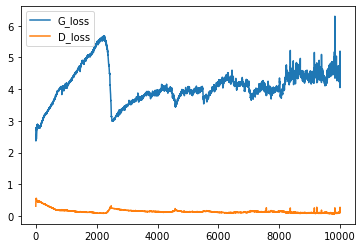

In [9]:
import matplotlib.pyplot as plt
plt.plot(G_loss_trace, label='G_loss')
plt.plot(D_loss_trace, label='D_loss')
plt.legend()
plt.show()

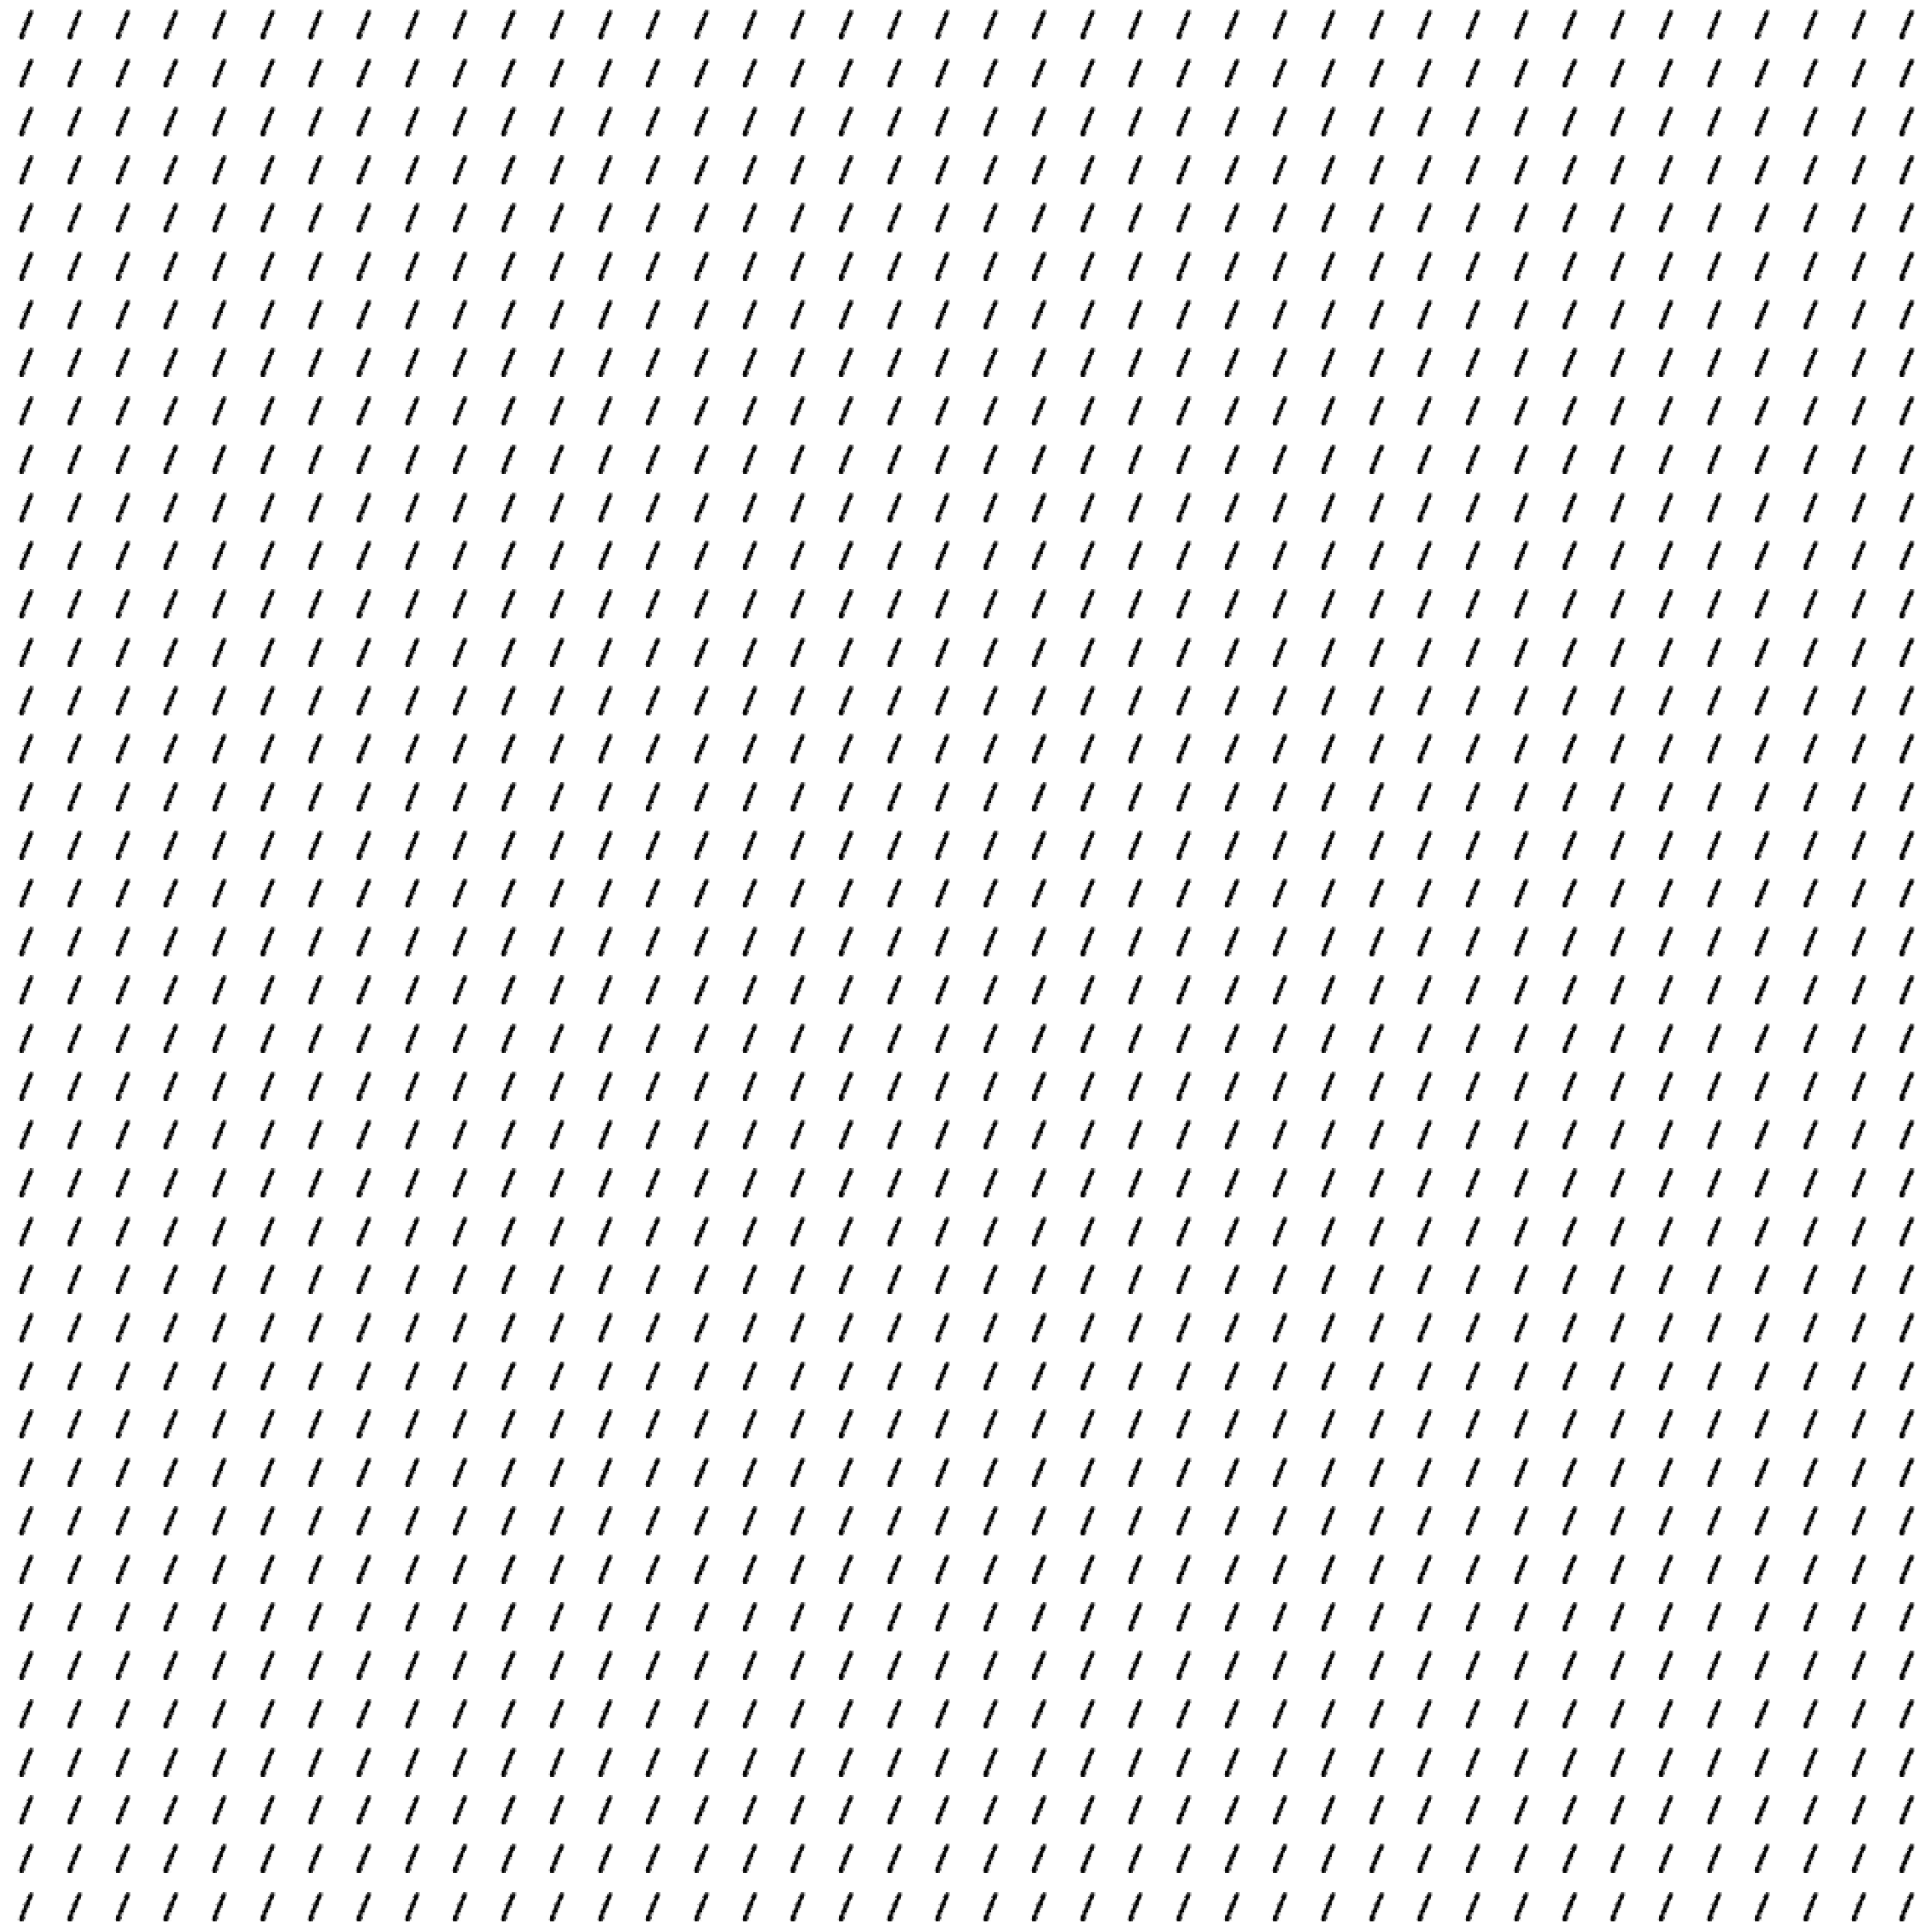

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=40, ncols=40, figsize=(40,40))

for i in range(40):
    for j in range(40):
        
        img = latent_space_walk[i*40+j].reshape((28,28))
            
        axes[i, j].imshow(img, cmap='binary')
        axes[i, j].axis('off')
            
plt.tight_layout()

plt.show()

In [5]:
import cv2
import os

image_folder = 'out_grid'
video_name = 'out_grid.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [2]:
import cv2
import os

image_folder = 'out_random'
video_name = 'out_random.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

# Reference

[ppplinday](https://github.com/ppplinday/Multiple-GAN-Tensorflow-Mnist)